# <font color='blue'>Projet 07 Data Science</font>
## Implémentez un modèle de scoring
## <font color='blue'>Partie 1 : Analyse exploratoire </font>

### <font color='green'>Auteur & Copyright : Julien Maisonnier (Fevrier 2022)</font>

# Introduction

La société <b>Prêt à dépenser</b> propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite <b>mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité</b> qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un <b>algorithme de classification</b> en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de <b>transparence</b> vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

<b>Prêt à dépenser décide donc de développer un dashboard interactif</b> pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement.

## Mission

<ol>
    <li>Construire un <b>modèle de scoring</b> qui donnera une <b>prédiction sur la probabilité de faillite d'un client de façon automatique</b>.</li>
<li>Construire un <b>dashboard interactif</b> à destination des gestionnaires de la relation client permettant <b>d'interpréter les prédictions faites par le modèle</b>, et d’améliorer la connaissance client des chargés de relation client.</li>
</ol>

<b>Recommendation</b>

Sélectionner un kernel Kaggle pour vous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring et analyserez ce kernel et l’adapterez pour s'assurer qu’il répond aux besoins de la mission.

Se focaliser sur l’élaboration du modèle, son optimisation et sa compréhension.

## Spécifications minimum du dashboard
- Permettre de <b>visualiser le score et l’interprétation de ce score pour chaque client</b> de façon intelligible pour une personne non experte en data science.
- Permettre de <b>visualiser des informations descriptives relatives à un client</b> (via un système de filtre).
- Permettre de <b>comparer les informations descriptives relatives à un client à l’ensemble des clients</b> ou à un groupe de clients similaires.

## Reference
#### Nous nous sommes inspirés d'un script Kaggle pour le feature engineering (mean or median values) appliqué aux tableaux "previous applications" and "credit card balance":
#### https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm/script
#### Note: le reste de de la strategie de selection de variables et feature engineering est issu de notre propre invention

## Les données

https://www.kaggle.com/c/home-credit-default-risk/data



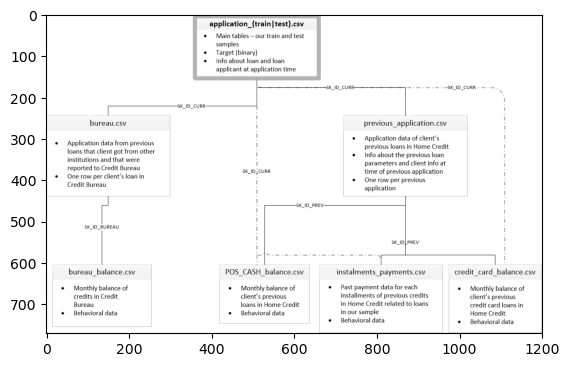

In [352]:
file_name_data = '_home_credit.png'
image_data = imread('./data/' + file_name_data)
# fig, ax = subplots(figsize=(18, 2))
# plt.imshow(image_data, origin = 'lower', aspect='1000',  extent = [0, 1000, 0, 1])
plt.imshow(image_data)

# A - Librairies Python

In [353]:
%matplotlib inline  

import numpy as np

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt

from matplotlib.image import imread

from datetime import datetime

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from matplotlib.image import imread

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix, adjusted_rand_score

from matplotlib.ticker import PercentFormatter

# -      

from math import pi

from datetime import datetime

from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing

from sklearn import dummy

from sklearn.cluster import KMeans

from sklearn.cluster import DBSCAN

from sklearn import manifold

from sklearn import datasets

from sklearn import decomposition

from sklearn import ensemble

from sklearn import discriminant_analysis

from sklearn import random_projection

from matplotlib import offsetbox

from mpl_toolkits.mplot3d import Axes3D


# --------------------------------

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import RobustScaler, OneHotEncoder

from sklearn import preprocessing

from sklearn import linear_model

from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import Ridge, Lasso

from sklearn.svm import LinearSVR

from sklearn import metrics

from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error

from sklearn import dummy

from sklearn.model_selection import GridSearchCV

# ------------------------

from sklearn.ensemble import GradientBoostingClassifier

# -------------------------------
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

#### Disable auto-scrolling so that graphs display properly

In [354]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

#### PEP 8  check

In [355]:
# %load_ext pycodestyle_magic

In [356]:
# %flake8_on

# B - Methodes

In [357]:
def ft_contract_status_num(NAME_CONTRACT_STATUS):
    if NAME_CONTRACT_STATUS == 'Approved':
        return 1
    elif NAME_CONTRACT_STATUS == 'Refused':
        return 0
    elif NAME_CONTRACT_STATUS == 'Canceled':
        return 0.6
    elif NAME_CONTRACT_STATUS == 'Unused offer':
        return 0.6
    else:
        return 0

# C - Import des datasets & Feature Engineering

## 0 - HomeCredit_columns_description.csv

In [358]:
df_homecredit_columns_description =\
    pd.read_csv('./data/HomeCredit_columns_description-copy.csv', encoding= 'unicode_escape')

In [359]:
print("Dataset light pour graphs et model cleaned : %d colonnes & %d lignes"
      % (df_homecredit_columns_description.shape[1],
         df_homecredit_columns_description.shape[0]))

Dataset light pour graphs et model cleaned : 5 colonnes & 219 lignes


In [360]:
df_homecredit_columns_description.columns

Index(['index', 'Table', 'Row', 'Description', 'Special'], dtype='object')

In [361]:
df_homecredit_columns_description.head()

,index,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [362]:
df_homecredit_columns_description.Table.value_counts()

application_{train|test}.csv    122
previous_application.csv         38
credit_card_balance.csv          23
bureau.csv                       17
installments_payments.csv         8
POS_CASH_balance.csv              8
bureau_balance.csv                3
Name: Table, dtype: int64

In [363]:
df_homecredit_columns_description[df_homecredit_columns_description['Table']=='application_{train|test}.csv'][['Row', 'Description']]

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,Target variable (1 - client with payment diffi...
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...
118,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...
119,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...
120,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...


In [364]:
df_description_prevappl = df_homecredit_columns_description[df_homecredit_columns_description['Table']=='previous_application.csv'][['Row', 'Description']].copy(deep=True)
df_description_prevappl


,Row,Description
173,SK_ID_PREV,ID of previous credit in Home credit related t...
174,SK_ID_CURR,ID of loan in our sample
175,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa..."
176,AMT_ANNUITY,Annuity of previous application
177,AMT_APPLICATION,For how much credit did client ask on the prev...
178,AMT_CREDIT,Final credit amount on the previous applicatio...
179,AMT_DOWN_PAYMENT,Down payment on the previous application
180,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...
181,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply ...
182,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client ...


In [365]:
for index, row in df_description_prevappl.iterrows():
    print(row['Row'], '\n', row['Description'], '\n')

SK_ID_PREV  
 ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loan applications in Home Credit, previous application could, but not necessarily have to lead to credit)  

SK_ID_CURR 
 ID of loan in our sample 

NAME_CONTRACT_TYPE 
 Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application 

AMT_ANNUITY 
 Annuity of previous application 

AMT_APPLICATION 
 For how much credit did client ask on the previous application 

AMT_CREDIT 
 Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT 

AMT_DOWN_PAYMENT 
 Down payment on the previous application 

AMT_GOODS_PRICE 
 Goods price of good that client asked for (if applicable) on the previous application 

WEEKDAY_APPR_PROCESS_START 


In [366]:
list_keep_var_previous_application = ['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_TYPE', 
                                      'NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON',
                                      'NAME_CASH_LOAN_PURPOSE',
                                      'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 
                                      'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
                                      'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 
                                      'NAME_PAYMENT_TYPE', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',  
                                      'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
                                      'DAYS_DECISION', 'CNT_PAYMENT',
                                      'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',  
                                     ]

list_keep_var_previous_application_new = ['SK_ID_CURR', 'SK_ID_PREV', 'NAME_CONTRACT_TYPE', 
                                      'NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON',
                                      'NAME_CASH_LOAN_PURPOSE',
                                      'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 
                                      'AMT_DOWN_PAYMENT',
                                      'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 
                                      'NAME_PAYMENT_TYPE', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',  
                                      'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
                                      'DAYS_DECISION',
                                      'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',  
                                     ]

list_keep_2nd_var_previous_application = ['NFLAG_INSURED_ON_APPROVAL',
                                      'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
                                      'DAYS_LAST_DUE', 'DAYS_TERMINATION',
                                     ]                                     

list_key_var_previous_application_new = ['AMT_CREDIT_minus_AMT_APPLICATION'
                                        ]         

list_remove_var_previous_application = ['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
                                        'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
                                        'NAME_TYPE_SUITE', 'RATE_INTEREST_PRIMARY',
                                        'RATE_INTEREST_PRIVILEGED','RATE_DOWN_PAYMENT',
                                       ]


In [367]:
for index, row in df_description_prevappl.iterrows():
    if row['Row'] in list_keep_var_previous_application:
        print(row['Row'], '\n', row['Description'], '\n')

SK_ID_CURR 
 ID of loan in our sample 

NAME_CONTRACT_TYPE 
 Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application 

AMT_ANNUITY 
 Annuity of previous application 

AMT_APPLICATION 
 For how much credit did client ask on the previous application 

AMT_CREDIT 
 Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT 

AMT_DOWN_PAYMENT 
 Down payment on the previous application 

AMT_GOODS_PRICE 
 Goods price of good that client asked for (if applicable) on the previous application 

NAME_CASH_LOAN_PURPOSE 
 Purpose of the cash loan 

NAME_CONTRACT_STATUS 
 Contract status (approved, cancelled, ...) of previous application 

DAYS_DECISION 
 Relative to current application when was the decision about previous application made 

NAME_PAYMENT_TYPE 
 Payment

## 1a - application_train.csv

#### Analysis data description

In [368]:
df_description_train = df_homecredit_columns_description[df_homecredit_columns_description['Table']=='application_{train|test}.csv'][['Row', 'Description']].copy(deep=True)
df_description_train


,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,Target variable (1 - client with payment diffi...
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...
118,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...
119,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...
120,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...


In [369]:
for index, row in df_description_train.iterrows():
    print(row['Row'], '\n', row['Description'], '\n')

SK_ID_CURR 
 ID of loan in our sample 

TARGET 
 Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases) 

NAME_CONTRACT_TYPE 
 Identification if loan is cash or revolving 

CODE_GENDER 
 Gender of the client 

FLAG_OWN_CAR 
 Flag if the client owns a car 

FLAG_OWN_REALTY 
 Flag if client owns a house or flat 

CNT_CHILDREN 
 Number of children the client has 

AMT_INCOME_TOTAL 
 Income of the client 

AMT_CREDIT 
 Credit amount of the loan 

AMT_ANNUITY 
 Loan annuity 

AMT_GOODS_PRICE 
 For consumer loans it is the price of the goods for which the loan is given 

NAME_TYPE_SUITE 
 Who was accompanying client when he was applying for the loan 

NAME_INCOME_TYPE 
 Clients income type (businessman, working, maternity leave,) 

NAME_EDUCATION_TYPE 
 Level of highest education the client achieved 

NAME_FAMILY_STATUS 
 Family status of the client 

NAME_HOU

COMMONAREA_MEDI 
 Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

ELEVATORS_MEDI 
 Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

ENTRANCES_MEDI 
 Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor 

FLOORSMAX_MEDI 
 Normalized information about building where the client lives, What is average (_AVG suffix), m

#### Load data

In [370]:
df_application_train_raw = pd.read_csv(
    './data/application_train.csv', low_memory=False)

In [371]:
print("Dataset light pour graphs et model cleaned : %d colonnes & %d lignes"
      % (df_application_train_raw.shape[1], df_application_train_raw.shape[0]))

Dataset light pour graphs et model cleaned : 122 colonnes & 307511 lignes


In [372]:
df_application_train_raw.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [373]:
df_application_train_raw.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [374]:
df_application_train_raw

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [375]:
null_data = df_application_train_raw[df_application_train_raw.isnull().any(axis=1)]
null_data.loc[0,:]

SK_ID_CURR                        100002
TARGET                                 1
NAME_CONTRACT_TYPE            Cash loans
CODE_GENDER                            M
FLAG_OWN_CAR                           N
                                 ...    
AMT_REQ_CREDIT_BUREAU_DAY            0.0
AMT_REQ_CREDIT_BUREAU_WEEK           0.0
AMT_REQ_CREDIT_BUREAU_MON            0.0
AMT_REQ_CREDIT_BUREAU_QRT            0.0
AMT_REQ_CREDIT_BUREAU_YEAR           1.0
Name: 0, Length: 122, dtype: object

##### Il n'y a qu'une seule reference SK_ID_CURR, ie valeurs uniques

In [376]:
df_application_train_raw.SK_ID_CURR.value_counts().max()

1

In [377]:
df_application_train_raw.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


## 1b - application_test.csv

In [378]:
df_application_test_raw = pd.read_csv(
    './data/application_test.csv', low_memory=False)

In [379]:
print("Dataset light pour graphs et model cleaned : %d colonnes & %d lignes"
      % (df_application_test_raw.shape[1], df_application_test_raw.shape[0]))

Dataset light pour graphs et model cleaned : 121 colonnes & 48744 lignes


In [380]:
df_application_test_raw.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121)

In [381]:
df_application_test_raw.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [382]:
df_application_test_raw.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000


## 2 - previous_application.csv

In [383]:
df_previous_application_raw = \
    pd.read_csv('./data/previous_application.csv',
                low_memory=False)

In [384]:
print("Dataset light pour graphs et model cleaned : %d colonnes & %d lignes"
      % (df_previous_application_raw.shape[1],
         df_previous_application_raw.shape[0]))

Dataset light pour graphs et model cleaned : 37 colonnes & 1670214 lignes


In [385]:
df_previous_application_raw.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

### Option pour selectionner des variables de previous_application (currently by-passed)

In [386]:
len(list_keep_var_previous_application)

23

In [387]:
df_previous_application_raw.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


## Selection variables : commented out

In [388]:
# df_previous_application_raw = df_previous_application_raw.loc[:, list_keep_var_previous_application]
df_previous_application_raw

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [389]:
df_previous_application_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [390]:
df_sample_test = df_previous_application_raw[['NAME_CONTRACT_TYPE', 'AMT_GOODS_PRICE', 'CNT_PAYMENT','AMT_DOWN_PAYMENT', 'AMT_CREDIT', 'AMT_ANNUITY']].copy(deep=True)
df_sample_test

,NAME_CONTRACT_TYPE,AMT_GOODS_PRICE,CNT_PAYMENT,AMT_DOWN_PAYMENT,AMT_CREDIT,AMT_ANNUITY
0,Consumer loans,17145.0,12.0,0.0,17145.0,1730.430
1,Cash loans,607500.0,36.0,NaN,679671.0,25188.615
2,Cash loans,112500.0,12.0,NaN,136444.5,15060.735
3,Cash loans,450000.0,12.0,NaN,470790.0,47041.335
4,Cash loans,337500.0,24.0,NaN,404055.0,31924.395
...,...,...,...,...,...,...
1670209,Consumer loans,267295.5,30.0,0.0,311400.0,14704.290
1670210,Consumer loans,87750.0,12.0,29250.0,64291.5,6622.020
1670211,Consumer loans,105237.0,10.0,10525.5,102523.5,11520.855
1670212,Cash loans,180000.0,12.0,NaN,191880.0,18821.520


In [391]:
df_sample_test['ratio_AMT_DOWN_PAYMENT_credit'] = df_sample_test['AMT_DOWN_PAYMENT'] / df_sample_test['AMT_CREDIT'] * 100
df_sample_test

,NAME_CONTRACT_TYPE,AMT_GOODS_PRICE,CNT_PAYMENT,AMT_DOWN_PAYMENT,AMT_CREDIT,AMT_ANNUITY,ratio_AMT_DOWN_PAYMENT_credit
0,Consumer loans,17145.0,12.0,0.0,17145.0,1730.430,0.000000
1,Cash loans,607500.0,36.0,NaN,679671.0,25188.615,NaN
2,Cash loans,112500.0,12.0,NaN,136444.5,15060.735,NaN
3,Cash loans,450000.0,12.0,NaN,470790.0,47041.335,NaN
4,Cash loans,337500.0,24.0,NaN,404055.0,31924.395,NaN
...,...,...,...,...,...,...,...
1670209,Consumer loans,267295.5,30.0,0.0,311400.0,14704.290,0.000000
1670210,Consumer loans,87750.0,12.0,29250.0,64291.5,6622.020,45.495905
1670211,Consumer loans,105237.0,10.0,10525.5,102523.5,11520.855,10.266427
1670212,Cash loans,180000.0,12.0,NaN,191880.0,18821.520,NaN


In [392]:
df_sample_test['ratio_AMT_ANNUITY_credit'] = df_sample_test['AMT_ANNUITY'] / df_sample_test['AMT_CREDIT'] * 100
df_sample_test

,NAME_CONTRACT_TYPE,AMT_GOODS_PRICE,CNT_PAYMENT,AMT_DOWN_PAYMENT,AMT_CREDIT,AMT_ANNUITY,ratio_AMT_DOWN_PAYMENT_credit,ratio_AMT_ANNUITY_credit
0,Consumer loans,17145.0,12.0,0.0,17145.0,1730.430,0.000000,10.092913
1,Cash loans,607500.0,36.0,NaN,679671.0,25188.615,NaN,3.706001
2,Cash loans,112500.0,12.0,NaN,136444.5,15060.735,NaN,11.037993
3,Cash loans,450000.0,12.0,NaN,470790.0,47041.335,NaN,9.992000
4,Cash loans,337500.0,24.0,NaN,404055.0,31924.395,NaN,7.901002
...,...,...,...,...,...,...,...,...
1670209,Consumer loans,267295.5,30.0,0.0,311400.0,14704.290,0.000000,4.721994
1670210,Consumer loans,87750.0,12.0,29250.0,64291.5,6622.020,45.495905,10.299993
1670211,Consumer loans,105237.0,10.0,10525.5,102523.5,11520.855,10.266427,11.237282
1670212,Cash loans,180000.0,12.0,NaN,191880.0,18821.520,NaN,9.809006


In [393]:
df_sample_test['ratio_AMT_GOODS_PRICE_credit'] = df_sample_test['AMT_GOODS_PRICE'] / df_sample_test['AMT_CREDIT'] * 100
df_sample_test

,NAME_CONTRACT_TYPE,AMT_GOODS_PRICE,CNT_PAYMENT,AMT_DOWN_PAYMENT,AMT_CREDIT,AMT_ANNUITY,ratio_AMT_DOWN_PAYMENT_credit,ratio_AMT_ANNUITY_credit,ratio_AMT_GOODS_PRICE_credit
0,Consumer loans,17145.0,12.0,0.0,17145.0,1730.430,0.000000,10.092913,100.000000
1,Cash loans,607500.0,36.0,NaN,679671.0,25188.615,NaN,3.706001,89.381480
2,Cash loans,112500.0,12.0,NaN,136444.5,15060.735,NaN,11.037993,82.451106
3,Cash loans,450000.0,12.0,NaN,470790.0,47041.335,NaN,9.992000,95.584018
4,Cash loans,337500.0,24.0,NaN,404055.0,31924.395,NaN,7.901002,83.528233
...,...,...,...,...,...,...,...,...,...
1670209,Consumer loans,267295.5,30.0,0.0,311400.0,14704.290,0.000000,4.721994,85.836705
1670210,Consumer loans,87750.0,12.0,29250.0,64291.5,6622.020,45.495905,10.299993,136.487716
1670211,Consumer loans,105237.0,10.0,10525.5,102523.5,11520.855,10.266427,11.237282,102.646710
1670212,Cash loans,180000.0,12.0,NaN,191880.0,18821.520,NaN,9.809006,93.808630


In [394]:
df_sample_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 9 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   NAME_CONTRACT_TYPE             1670214 non-null  object 
 1   AMT_GOODS_PRICE                1284699 non-null  float64
 2   CNT_PAYMENT                    1297984 non-null  float64
 3   AMT_DOWN_PAYMENT               774370 non-null   float64
 4   AMT_CREDIT                     1670213 non-null  float64
 5   AMT_ANNUITY                    1297979 non-null  float64
 6   ratio_AMT_DOWN_PAYMENT_credit  774370 non-null   float64
 7   ratio_AMT_ANNUITY_credit       1296355 non-null  float64
 8   ratio_AMT_GOODS_PRICE_credit   1281971 non-null  float64
dtypes: float64(8), object(1)
memory usage: 114.7+ MB


In [395]:
df_application_train_raw.NAME_CONTRACT_TYPE.value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [396]:
df_sample_test.NAME_CONTRACT_TYPE.value_counts()

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE, dtype: int64

In [397]:
df_revolving = df_sample_test[df_sample_test.NAME_CONTRACT_TYPE == 'Revolving loans'].copy(deep=True)
df_revolving

,NAME_CONTRACT_TYPE,AMT_GOODS_PRICE,CNT_PAYMENT,AMT_DOWN_PAYMENT,AMT_CREDIT,AMT_ANNUITY,ratio_AMT_DOWN_PAYMENT_credit,ratio_AMT_ANNUITY_credit,ratio_AMT_GOODS_PRICE_credit
17,Revolving loans,180000.0,0.0,NaN,180000.0,9000.0,NaN,5.0,100.0
34,Revolving loans,202500.0,0.0,NaN,202500.0,10125.0,NaN,5.0,100.0
45,Revolving loans,292500.0,0.0,NaN,292500.0,14625.0,NaN,5.0,100.0
49,Revolving loans,225000.0,0.0,NaN,225000.0,11250.0,NaN,5.0,100.0
50,Revolving loans,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1669960,Revolving loans,NaN,0.0,NaN,225000.0,11250.0,NaN,5.0,NaN
1669962,Revolving loans,NaN,0.0,NaN,450000.0,22500.0,NaN,5.0,NaN
1670191,Revolving loans,45000.0,0.0,NaN,45000.0,2250.0,NaN,5.0,100.0
1670192,Revolving loans,NaN,0.0,NaN,67500.0,3375.0,NaN,5.0,NaN


In [398]:
df_revolving.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193164 entries, 17 to 1670193
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   NAME_CONTRACT_TYPE             193164 non-null  object 
 1   AMT_GOODS_PRICE                93329 non-null   float64
 2   CNT_PAYMENT                    144985 non-null  float64
 3   AMT_DOWN_PAYMENT               2395 non-null    float64
 4   AMT_CREDIT                     193163 non-null  float64
 5   AMT_ANNUITY                    144984 non-null  float64
 6   ratio_AMT_DOWN_PAYMENT_credit  2395 non-null    float64
 7   ratio_AMT_ANNUITY_credit       143414 non-null  float64
 8   ratio_AMT_GOODS_PRICE_credit   91945 non-null   float64
dtypes: float64(8), object(1)
memory usage: 14.7+ MB


### Analyse valeurs medianes non-NaN de 'Revolving loans' : ratio_AMT_DOWN_PAYMENT_credit et ratio_AMT_ANNUITY_credit

In [399]:
df_revolving_non_nan = df_revolving.dropna(subset=['AMT_DOWN_PAYMENT'])
df_revolving_non_nan

,NAME_CONTRACT_TYPE,AMT_GOODS_PRICE,CNT_PAYMENT,AMT_DOWN_PAYMENT,AMT_CREDIT,AMT_ANNUITY,ratio_AMT_DOWN_PAYMENT_credit,ratio_AMT_ANNUITY_credit,ratio_AMT_GOODS_PRICE_credit
200,Revolving loans,157500.0,0.0,0.0,157500.0,7875.0,0.000000,5.0,100.000000
412,Revolving loans,135000.0,0.0,0.0,135000.0,6750.0,0.000000,5.0,100.000000
1717,Revolving loans,157500.0,0.0,0.0,157500.0,7875.0,0.000000,5.0,100.000000
1786,Revolving loans,157500.0,0.0,0.0,157500.0,7875.0,0.000000,5.0,100.000000
2704,Revolving loans,135000.0,0.0,0.0,135000.0,6750.0,0.000000,5.0,100.000000
...,...,...,...,...,...,...,...,...,...
1664574,Revolving loans,157500.0,0.0,0.0,157500.0,7875.0,0.000000,5.0,100.000000
1664737,Revolving loans,157500.0,0.0,0.0,157500.0,7875.0,0.000000,5.0,100.000000
1665555,Revolving loans,67500.0,0.0,6750.0,63000.0,4410.0,10.714286,7.0,107.142857
1666238,Revolving loans,135000.0,0.0,0.0,135000.0,13500.0,0.000000,10.0,100.000000


In [400]:
df_revolving_non_nan.describe()

,AMT_GOODS_PRICE,CNT_PAYMENT,AMT_DOWN_PAYMENT,AMT_CREDIT,AMT_ANNUITY,ratio_AMT_DOWN_PAYMENT_credit,ratio_AMT_ANNUITY_credit,ratio_AMT_GOODS_PRICE_credit
count,2395.000000,2391.0,2395.000000,2395.000000,2391.000000,2395.000000,2391.000000,2395.000000
mean,124712.098177,0.0,3260.822392,123523.590814,6482.728984,6.327730,5.480866,103.013960
std,76856.337462,0.0,9407.541822,76855.250293,3740.959578,19.304191,0.922904,20.573158
min,0.000000,0.0,0.000000,27000.000000,1890.000000,0.000000,3.750000,0.000000
25%,69214.500000,0.0,0.000000,63000.000000,4410.000000,0.000000,5.000000,100.000000
50%,135000.000000,0.0,0.000000,135000.000000,6750.000000,0.000000,5.000000,100.000000
75%,157500.000000,0.0,0.000000,157500.000000,7875.000000,0.000000,5.000000,100.000000
max,675000.000000,0.0,135000.000000,675000.000000,33750.000000,216.666667,10.000000,314.750000


In [401]:
df_revolving_median_ratio_AMT_DOWN_PAYMENT_credit = df_revolving_non_nan.describe().loc['50%','ratio_AMT_DOWN_PAYMENT_credit']
df_revolving_median_ratio_AMT_DOWN_PAYMENT_credit

0.0

In [402]:
df_revolving_median_ratio_AMT_ANNUITY_credit = df_revolving_non_nan.describe().loc['50%','ratio_AMT_ANNUITY_credit']
df_revolving_median_ratio_AMT_ANNUITY_credit

5.0

In [403]:
df_revolving_non_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2395 entries, 200 to 1667191
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   NAME_CONTRACT_TYPE             2395 non-null   object 
 1   AMT_GOODS_PRICE                2395 non-null   float64
 2   CNT_PAYMENT                    2391 non-null   float64
 3   AMT_DOWN_PAYMENT               2395 non-null   float64
 4   AMT_CREDIT                     2395 non-null   float64
 5   AMT_ANNUITY                    2391 non-null   float64
 6   ratio_AMT_DOWN_PAYMENT_credit  2395 non-null   float64
 7   ratio_AMT_ANNUITY_credit       2391 non-null   float64
 8   ratio_AMT_GOODS_PRICE_credit   2395 non-null   float64
dtypes: float64(8), object(1)
memory usage: 187.1+ KB


In [404]:
df_revolving_non_goods = df_revolving.dropna(subset=['AMT_GOODS_PRICE'])
df_revolving_non_goods

,NAME_CONTRACT_TYPE,AMT_GOODS_PRICE,CNT_PAYMENT,AMT_DOWN_PAYMENT,AMT_CREDIT,AMT_ANNUITY,ratio_AMT_DOWN_PAYMENT_credit,ratio_AMT_ANNUITY_credit,ratio_AMT_GOODS_PRICE_credit
17,Revolving loans,180000.0,0.0,NaN,180000.0,9000.0,NaN,5.0,100.0
34,Revolving loans,202500.0,0.0,NaN,202500.0,10125.0,NaN,5.0,100.0
45,Revolving loans,292500.0,0.0,NaN,292500.0,14625.0,NaN,5.0,100.0
49,Revolving loans,225000.0,0.0,NaN,225000.0,11250.0,NaN,5.0,100.0
82,Revolving loans,900000.0,0.0,NaN,900000.0,45000.0,NaN,5.0,100.0
...,...,...,...,...,...,...,...,...,...
1669792,Revolving loans,0.0,0.0,NaN,157500.0,7875.0,NaN,5.0,0.0
1669796,Revolving loans,90000.0,0.0,NaN,90000.0,4500.0,NaN,5.0,100.0
1669833,Revolving loans,180000.0,0.0,NaN,180000.0,9000.0,NaN,5.0,100.0
1669840,Revolving loans,135000.0,0.0,NaN,135000.0,6750.0,NaN,5.0,100.0


In [405]:
df_revolving_non_goods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93329 entries, 17 to 1670191
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   NAME_CONTRACT_TYPE             93329 non-null  object 
 1   AMT_GOODS_PRICE                93329 non-null  float64
 2   CNT_PAYMENT                    93325 non-null  float64
 3   AMT_DOWN_PAYMENT               2395 non-null   float64
 4   AMT_CREDIT                     93329 non-null  float64
 5   AMT_ANNUITY                    93325 non-null  float64
 6   ratio_AMT_DOWN_PAYMENT_credit  2395 non-null   float64
 7   ratio_AMT_ANNUITY_credit       91940 non-null  float64
 8   ratio_AMT_GOODS_PRICE_credit   91945 non-null  float64
dtypes: float64(8), object(1)
memory usage: 7.1+ MB


In [406]:
data_graph = list(df_revolving_non_nan['ratio_AMT_DOWN_PAYMENT_credit'])
data_graph[:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.18, 0.0, 0.0, 0.0]

(array([1965.,  201.,   79.,   37.,   25.,   66.]),
 array([  0,  10,  20,  30,  40,  50, 100]),
 <BarContainer object of 6 artists>)

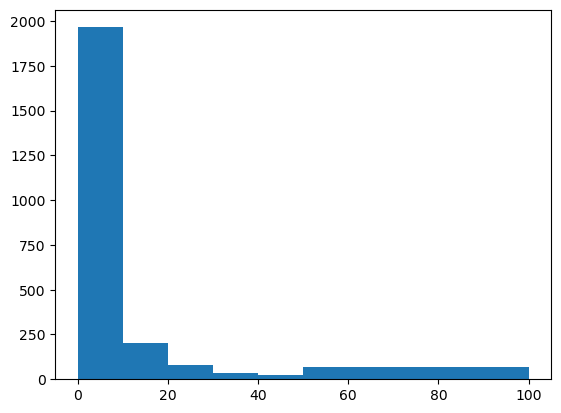

In [407]:
plt.hist(df_revolving_non_nan['ratio_AMT_DOWN_PAYMENT_credit'], bins=[0, 10, 20, 30, 40, 50, 100])

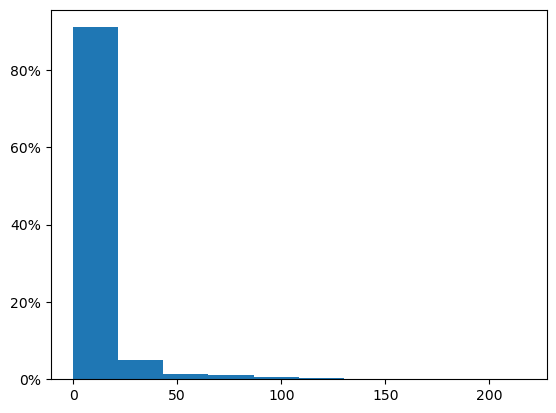

In [408]:
plt.hist(data_graph, weights=np.ones(len(data_graph)) / len(data_graph))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [409]:
df_revolving_non_nan.value_counts()

NAME_CONTRACT_TYPE  AMT_GOODS_PRICE  CNT_PAYMENT  AMT_DOWN_PAYMENT  AMT_CREDIT  AMT_ANNUITY  ratio_AMT_DOWN_PAYMENT_credit  ratio_AMT_ANNUITY_credit  ratio_AMT_GOODS_PRICE_credit
Revolving loans     157500.0         0.0          0.0               157500.0    7875.0       0.000000                       5.0                       100.000000                      727
                    135000.0         0.0          0.0               135000.0    6750.0       0.000000                       5.0                       100.000000                      361
                    90000.0          0.0          0.0               90000.0     4500.0       0.000000                       5.0                       100.000000                      278
                    45000.0          0.0          0.0               45000.0     2250.0       0.000000                       5.0                       100.000000                      259
                    225000.0         0.0          0.0               225000.0 

In [410]:
df_cash = df_sample_test[df_sample_test.NAME_CONTRACT_TYPE == 'Cash loans'].copy(deep=True)
df_cash

,NAME_CONTRACT_TYPE,AMT_GOODS_PRICE,CNT_PAYMENT,AMT_DOWN_PAYMENT,AMT_CREDIT,AMT_ANNUITY,ratio_AMT_DOWN_PAYMENT_credit,ratio_AMT_ANNUITY_credit,ratio_AMT_GOODS_PRICE_credit
1,Cash loans,607500.0,36.0,NaN,679671.0,25188.615,NaN,3.706001,89.381480
2,Cash loans,112500.0,12.0,NaN,136444.5,15060.735,NaN,11.037993,82.451106
3,Cash loans,450000.0,12.0,NaN,470790.0,47041.335,NaN,9.992000,95.584018
4,Cash loans,337500.0,24.0,NaN,404055.0,31924.395,NaN,7.901002,83.528233
5,Cash loans,315000.0,18.0,NaN,340573.5,23703.930,NaN,6.960004,92.491048
...,...,...,...,...,...,...,...,...,...
1670206,Cash loans,180000.0,24.0,0.0,243936.0,19401.435,0.0,7.953494,73.789847
1670207,Cash loans,112500.0,12.0,0.0,112500.0,12607.875,0.0,11.207000,100.000000
1670208,Cash loans,315000.0,36.0,NaN,436216.5,22299.390,NaN,5.112001,72.211849
1670212,Cash loans,180000.0,12.0,NaN,191880.0,18821.520,NaN,9.809006,93.808630


In [411]:
df_cash.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747553 entries, 1 to 1670213
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   NAME_CONTRACT_TYPE             747553 non-null  object 
 1   AMT_GOODS_PRICE                463576 non-null  float64
 2   CNT_PAYMENT                    461563 non-null  float64
 3   AMT_DOWN_PAYMENT               47934 non-null   float64
 4   AMT_CREDIT                     747553 non-null  float64
 5   AMT_ANNUITY                    461563 non-null  float64
 6   ratio_AMT_DOWN_PAYMENT_credit  47934 non-null   float64
 7   ratio_AMT_ANNUITY_credit       461509 non-null  float64
 8   ratio_AMT_GOODS_PRICE_credit   462240 non-null  float64
dtypes: float64(8), object(1)
memory usage: 57.0+ MB


In [412]:
df_cash_non_nan_ann = df_cash.copy(deep=True)
df_cash_non_nan_ann = df_cash_non_nan_ann.dropna(subset=['AMT_ANNUITY'])
df_cash_non_nan_ann

,NAME_CONTRACT_TYPE,AMT_GOODS_PRICE,CNT_PAYMENT,AMT_DOWN_PAYMENT,AMT_CREDIT,AMT_ANNUITY,ratio_AMT_DOWN_PAYMENT_credit,ratio_AMT_ANNUITY_credit,ratio_AMT_GOODS_PRICE_credit
1,Cash loans,607500.0,36.0,NaN,679671.0,25188.615,NaN,3.706001,89.381480
2,Cash loans,112500.0,12.0,NaN,136444.5,15060.735,NaN,11.037993,82.451106
3,Cash loans,450000.0,12.0,NaN,470790.0,47041.335,NaN,9.992000,95.584018
4,Cash loans,337500.0,24.0,NaN,404055.0,31924.395,NaN,7.901002,83.528233
5,Cash loans,315000.0,18.0,NaN,340573.5,23703.930,NaN,6.960004,92.491048
...,...,...,...,...,...,...,...,...,...
1670206,Cash loans,180000.0,24.0,0.0,243936.0,19401.435,0.0,7.953494,73.789847
1670207,Cash loans,112500.0,12.0,0.0,112500.0,12607.875,0.0,11.207000,100.000000
1670208,Cash loans,315000.0,36.0,NaN,436216.5,22299.390,NaN,5.112001,72.211849
1670212,Cash loans,180000.0,12.0,NaN,191880.0,18821.520,NaN,9.809006,93.808630


### Analyse valeurs medianes non-NaN de Cash : ratio_AMT_DOWN_PAYMENT_credit et ratio_AMT_ANNUITY_credit

In [413]:
df_cash_non_nan_ann.describe()

,AMT_GOODS_PRICE,CNT_PAYMENT,AMT_DOWN_PAYMENT,AMT_CREDIT,AMT_ANNUITY,ratio_AMT_DOWN_PAYMENT_credit,ratio_AMT_ANNUITY_credit,ratio_AMT_GOODS_PRICE_credit
count,4.615630e+05,461563.000000,47214.0,4.615630e+05,461563.000000,47214.0,461509.000000,461509.000000
mean,4.446019e+05,28.350470,0.0,4.920582e+05,26119.824414,0.0,7.415279,89.936912
std,4.185487e+05,16.754465,0.0,4.528711e+05,17772.203427,0.0,4.140081,7.497411
min,0.000000e+00,3.000000,0.0,0.000000e+00,0.000000,0.0,2.208000,59.523101
25%,1.350000e+05,12.000000,0.0,1.678950e+05,13686.255000,0.0,4.250271,85.353363
50%,2.835000e+05,24.000000,0.0,3.299580e+05,21739.230000,0.0,6.423544,90.665028
75%,6.075000e+05,36.000000,0.0,6.750000e+05,33594.975000,0.0,9.942901,94.866160
max,4.050000e+06,84.000000,0.0,4.104351e+06,418058.145000,0.0,34.438000,100.000000


In [414]:
df_cash_median_ratio_AMT_DOWN_PAYMENT_credit = df_cash_non_nan_ann.describe().loc['50%','ratio_AMT_DOWN_PAYMENT_credit']
df_cash_median_ratio_AMT_DOWN_PAYMENT_credit

0.0

In [415]:
df_cash_median_ratio_AMT_ANNUITY_credit = df_cash_non_nan_ann.describe().loc['50%','ratio_AMT_ANNUITY_credit']
df_cash_median_ratio_AMT_ANNUITY_credit

6.423544489198097

(array([3.88028e+05, 6.80980e+04, 4.50500e+03, 7.46000e+02, 1.21000e+02,
        5.20000e+01, 4.00000e+00, 5.00000e+00, 0.00000e+00, 4.00000e+00]),
 array([     0.    ,  41805.8145,  83611.629 , 125417.4435, 167223.258 ,
        209029.0725, 250834.887 , 292640.7015, 334446.516 , 376252.3305,
        418058.145 ]),
 <BarContainer object of 10 artists>)

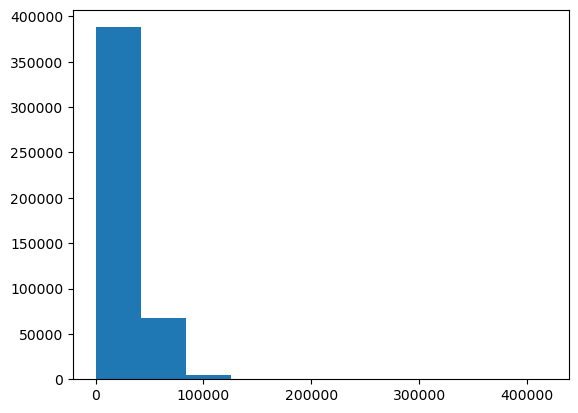

In [416]:
plt.hist(df_cash_non_nan_ann['AMT_ANNUITY'])

In [417]:
data_graph2 = list(df_cash_non_nan_ann['ratio_AMT_ANNUITY_credit'])
data_graph2[:10]

[3.706001138786266,
 11.037993469872367,
 9.991999617663927,
 7.901002338790511,
 6.960004228162203,
 3.385996890580604,
 5.614007853164094,
 6.977004671329393,
 5.6565,
 9.435850773430392]

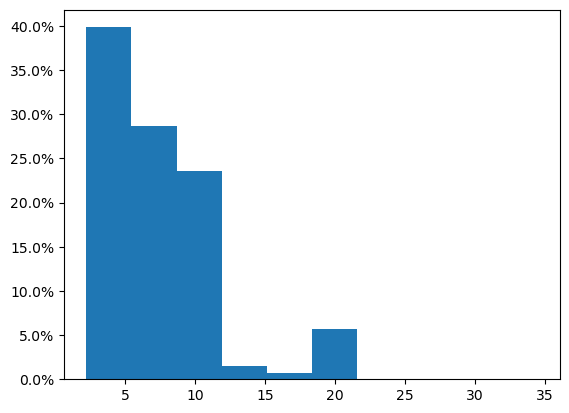

In [418]:
plt.hist(data_graph2, weights=np.ones(len(data_graph2)) / len(data_graph2))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [419]:
df_revolving_non_goods

,NAME_CONTRACT_TYPE,AMT_GOODS_PRICE,CNT_PAYMENT,AMT_DOWN_PAYMENT,AMT_CREDIT,AMT_ANNUITY,ratio_AMT_DOWN_PAYMENT_credit,ratio_AMT_ANNUITY_credit,ratio_AMT_GOODS_PRICE_credit
17,Revolving loans,180000.0,0.0,NaN,180000.0,9000.0,NaN,5.0,100.0
34,Revolving loans,202500.0,0.0,NaN,202500.0,10125.0,NaN,5.0,100.0
45,Revolving loans,292500.0,0.0,NaN,292500.0,14625.0,NaN,5.0,100.0
49,Revolving loans,225000.0,0.0,NaN,225000.0,11250.0,NaN,5.0,100.0
82,Revolving loans,900000.0,0.0,NaN,900000.0,45000.0,NaN,5.0,100.0
...,...,...,...,...,...,...,...,...,...
1669792,Revolving loans,0.0,0.0,NaN,157500.0,7875.0,NaN,5.0,0.0
1669796,Revolving loans,90000.0,0.0,NaN,90000.0,4500.0,NaN,5.0,100.0
1669833,Revolving loans,180000.0,0.0,NaN,180000.0,9000.0,NaN,5.0,100.0
1669840,Revolving loans,135000.0,0.0,NaN,135000.0,6750.0,NaN,5.0,100.0


In [420]:
df_revolving_non_goods[df_revolving_non_goods['ratio_AMT_GOODS_PRICE_credit']== np.inf]

,NAME_CONTRACT_TYPE,AMT_GOODS_PRICE,CNT_PAYMENT,AMT_DOWN_PAYMENT,AMT_CREDIT,AMT_ANNUITY,ratio_AMT_DOWN_PAYMENT_credit,ratio_AMT_ANNUITY_credit,ratio_AMT_GOODS_PRICE_credit
951006,Revolving loans,45000.0,0.0,NaN,0.0,0.0,NaN,NaN,inf


In [421]:
index_to_drop = df_revolving_non_goods[df_revolving_non_goods['ratio_AMT_GOODS_PRICE_credit']== np.inf].index.values[0]
index_to_drop

951006

In [422]:
df_revolving_non_goods = df_revolving_non_goods.drop(index_to_drop)

In [423]:
df_revolving_non_goods.describe()

,AMT_GOODS_PRICE,CNT_PAYMENT,AMT_DOWN_PAYMENT,AMT_CREDIT,AMT_ANNUITY,ratio_AMT_DOWN_PAYMENT_credit,ratio_AMT_ANNUITY_credit,ratio_AMT_GOODS_PRICE_credit
count,9.332800e+04,93324.0,2395.000000,9.332800e+04,93324.000000,2395.000000,91940.000000,91944.00000
mean,2.028508e+05,0.0,3260.822392,2.081634e+05,10247.391668,6.327730,4.973410,98.44012
std,2.146284e+05,0.0,9407.541822,2.105928e+05,10438.306208,19.304191,0.462143,43.98200
min,0.000000e+00,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000
25%,4.500000e+04,0.0,0.000000,4.500000e+04,2250.000000,0.000000,5.000000,100.00000
50%,1.350000e+05,0.0,0.000000,1.350000e+05,6750.000000,0.000000,5.000000,100.00000
75%,2.700000e+05,0.0,0.000000,2.475000e+05,12375.000000,0.000000,5.000000,100.00000
max,2.250000e+06,0.0,135000.000000,2.250000e+06,225000.000000,216.666667,32.500000,2000.00000


(array([9.0913e+04, 7.4300e+02, 1.4600e+02, 7.3000e+01, 2.7000e+01,
        2.9000e+01, 3.0000e+00, 1.0000e+00, 6.0000e+00, 3.0000e+00]),
 array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
        1800., 2000.]),
 <BarContainer object of 10 artists>)

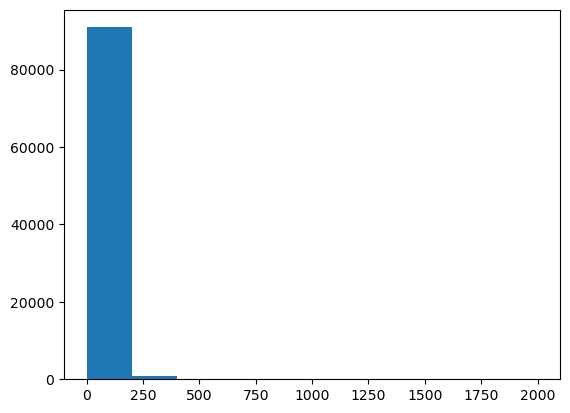

In [424]:
plt.hist(df_revolving_non_goods['ratio_AMT_GOODS_PRICE_credit'])

In [425]:
data_graph3 = list(df_revolving_non_goods['ratio_AMT_GOODS_PRICE_credit'])
data_graph3[:10]

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 0.0]

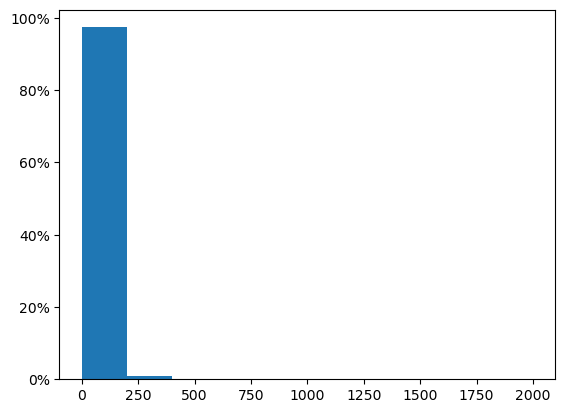

In [426]:


plt.hist(data_graph3, weights=np.ones(len(data_graph3)) / len(data_graph3))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [427]:
# df_cash_test = df_cash.copy(deep=True)

In [428]:
# df_cash_test['AMT_DOWN_PAYMENT'] = df_cash_test.apply(
#     lambda row: 0 if (np.isnan(row['AMT_DOWN_PAYMENT']) and (row['NAME_CONTRACT_TYPE'] == 'Cash loans')) else row['AMT_DOWN_PAYMENT'],
#     axis=1
# )

In [429]:
# df_cash_test.info()

In [430]:
# # replaced
# 747553 - 47934

In [431]:
df_previous_application_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [432]:
df_previous_application_raw.NAME_CONTRACT_TYPE.value_counts()

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE, dtype: int64

In [433]:
df_check_before = df_previous_application_raw[((df_previous_application_raw['NAME_CONTRACT_TYPE']=='Cash loans') | (df_previous_application_raw['NAME_CONTRACT_TYPE']=='Revolving loans')) & ((df_previous_application_raw['AMT_DOWN_PAYMENT'].isnull())|(df_previous_application_raw['AMT_ANNUITY'].isnull()))]
df_check_before

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,NaN,315000.0,SATURDAY,8,...,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670204,1407146,198989,Cash loans,36598.095,450000.0,570073.5,NaN,450000.0,THURSDAY,12,...,XNA,24.0,middle,Cash X-Sell: middle,NaN,NaN,NaN,NaN,NaN,NaN
1670205,2815130,338803,Cash loans,14584.050,135000.0,182956.5,NaN,135000.0,SATURDAY,10,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
1670208,1556789,209732,Cash loans,22299.390,315000.0,436216.5,NaN,315000.0,THURSDAY,17,...,XNA,36.0,middle,Cash X-Sell: middle,365243.0,-1249.0,-199.0,-919.0,-912.0,1.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [434]:
df_check_before.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891112 entries, 1 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_PREV                   891112 non-null  int64  
 1   SK_ID_CURR                   891112 non-null  int64  
 2   NAME_CONTRACT_TYPE           891112 non-null  object 
 3   AMT_ANNUITY                  556942 non-null  float64
 4   AMT_APPLICATION              891112 non-null  float64
 5   AMT_CREDIT                   891111 non-null  float64
 6   AMT_DOWN_PAYMENT             724 non-null     float64
 7   AMT_GOODS_PRICE              507300 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   891112 non-null  object 
 9   HOUR_APPR_PROCESS_START      891112 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  891112 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       891112 non-null  int64  
 12  RATE_DOWN_PAYMENT            724 non-null     float64
 13

In [435]:
df_check_before.NAME_CONTRACT_TYPE.value_counts()

Cash loans         700339
Revolving loans    190773
Name: NAME_CONTRACT_TYPE, dtype: int64

### VAleurs de remplacement NaN

In [436]:
df_revolving_median_ratio_AMT_ANNUITY_credit, df_revolving_median_ratio_AMT_DOWN_PAYMENT_credit

(5.0, 0.0)

In [437]:
df_cash_median_ratio_AMT_ANNUITY_credit, df_cash_median_ratio_AMT_DOWN_PAYMENT_credit

(6.423544489198097, 0.0)

In [438]:
df_previous_application_raw['AMT_DOWN_PAYMENT'] = df_previous_application_raw.apply(
    lambda row: df_revolving_median_ratio_AMT_DOWN_PAYMENT_credit if (np.isnan(row['AMT_DOWN_PAYMENT']) and (row['NAME_CONTRACT_TYPE'] == 'Cash loans')) else row['AMT_DOWN_PAYMENT'],
    axis=1
)

In [439]:
df_previous_application_raw['AMT_DOWN_PAYMENT'] = df_previous_application_raw.apply(
    lambda row: df_cash_median_ratio_AMT_DOWN_PAYMENT_credit if (np.isnan(row['AMT_DOWN_PAYMENT']) and (row['NAME_CONTRACT_TYPE'] == 'Revolving loans')) else row['AMT_DOWN_PAYMENT'],
    axis=1
)

In [440]:
df_previous_application_raw['AMT_ANNUITY'] = df_previous_application_raw.apply(
    lambda row: (row['AMT_CREDIT'] * 5 / 100) if (np.isnan(row['AMT_ANNUITY']) and (row['NAME_CONTRACT_TYPE'] == 'Revolving loans')) else row['AMT_ANNUITY'],
    axis=1
)
# df_cash_median_ratio_AMT_DOWN_PAYMENT_credit

In [441]:
df_previous_application_raw['AMT_ANNUITY'] = df_previous_application_raw.apply(
    lambda row: (row['AMT_CREDIT'] * df_cash_median_ratio_AMT_ANNUITY_credit / 100) if (np.isnan(row['AMT_ANNUITY']) and (row['NAME_CONTRACT_TYPE'] == 'Cash loans')) else row['AMT_ANNUITY'],
    axis=1
)

In [442]:
df_check_after = df_previous_application_raw[(df_previous_application_raw['NAME_CONTRACT_TYPE']=='Cash loans') | (df_previous_application_raw['NAME_CONTRACT_TYPE']=='Revolving loans')]
df_check_after

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,0.0,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,0.0,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,0.0,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,0.0,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
5,1383531,199383,Cash loans,23703.930,315000.0,340573.5,0.0,315000.0,SATURDAY,8,...,XNA,18.0,low_normal,Cash X-Sell: low,365243.0,-654.0,-144.0,-144.0,-137.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670206,2459206,238591,Cash loans,19401.435,180000.0,243936.0,0.0,180000.0,TUESDAY,13,...,XNA,24.0,high,Cash Street: high,365243.0,-1802.0,-1112.0,-1112.0,-1100.0,0.0
1670207,1662353,443544,Cash loans,12607.875,112500.0,112500.0,0.0,112500.0,MONDAY,10,...,XNA,12.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
1670208,1556789,209732,Cash loans,22299.390,315000.0,436216.5,0.0,315000.0,THURSDAY,17,...,XNA,36.0,middle,Cash X-Sell: middle,365243.0,-1249.0,-199.0,-919.0,-912.0,1.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,0.0,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [443]:
df_check_after.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 940717 entries, 1 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_PREV                   940717 non-null  int64  
 1   SK_ID_CURR                   940717 non-null  int64  
 2   NAME_CONTRACT_TYPE           940717 non-null  object 
 3   AMT_ANNUITY                  940717 non-null  float64
 4   AMT_APPLICATION              940717 non-null  float64
 5   AMT_CREDIT                   940716 non-null  float64
 6   AMT_DOWN_PAYMENT             940717 non-null  float64
 7   AMT_GOODS_PRICE              556905 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   940717 non-null  object 
 9   HOUR_APPR_PROCESS_START      940717 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  940717 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       940717 non-null  int64  
 12  RATE_DOWN_PAYMENT            50329 non-null   float64
 13

In [444]:
df_previous_application_raw['SK_ID_CURR'].value_counts()

187868    77
265681    73
173680    72
242412    68
206783    67
          ..
310932     1
308885     1
317081     1
335520     1
350314     1
Name: SK_ID_CURR, Length: 338857, dtype: int64

In [445]:
df_previous_application_raw[df_previous_application_raw['SK_ID_CURR']==187868]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
37305,1703693,187868,Cash loans,0.000,0.0,0.0,0.0,NaN,WEDNESDAY,2,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
56117,1677569,187868,Cash loans,0.000,0.0,0.0,0.0,NaN,SATURDAY,9,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
67781,1651393,187868,Cash loans,0.000,0.0,0.0,0.0,NaN,SATURDAY,7,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
92787,1173037,187868,Cash loans,0.000,0.0,0.0,0.0,NaN,THURSDAY,9,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
170959,2636986,187868,Cash loans,0.000,0.0,0.0,0.0,NaN,WEDNESDAY,8,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552993,2455456,187868,Cash loans,0.000,0.0,0.0,0.0,NaN,MONDAY,6,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1575005,1753307,187868,Cash loans,0.000,0.0,0.0,0.0,NaN,TUESDAY,4,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1581066,1404221,187868,Cash loans,0.000,0.0,0.0,0.0,NaN,FRIDAY,3,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1636755,2515824,187868,Cash loans,0.000,0.0,0.0,0.0,NaN,WEDNESDAY,2,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


## On eliminne les colonnes vides

In [446]:
df_previous_application_raw = df_previous_application_raw.drop(columns=['RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED'])
df_previous_application_raw

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,0.0,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,0.0,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,0.0,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,0.0,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,0.0,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


## On eliminne les colonnes problematiques - commented out

In [447]:
# df_previous_application_raw = df_previous_application_raw.drop(columns=['AMT_GOODS_PRICE', 'CNT_PAYMENT'])
# df_previous_application_raw

## On Elimine toutes les lignes ne correspondant pas a 'Revolving loans' et 'Cash loans' - commented out

In [448]:
# df_previous_application_raw = df_previous_application_raw[(df_previous_application_raw.NAME_CONTRACT_TYPE == 'Cash loans') | (df_previous_application_raw.NAME_CONTRACT_TYPE == 'Revolving loans')]
# df_previous_application_raw

### On n'elimine plus les lignes avec valeur NaN

In [449]:
# df_previous_application_raw.dropna(inplace=True)

In [450]:
df_previous_application_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 35 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1632149 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             1664758 non-null  float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

### ratio_AMT_DOWN_PAYMENT_credit	ratio_AMT_ANNUITY_credit

In [451]:
df_previous_application_raw['ratio_AMT_DOWN_PAYMENT_credit'] = df_previous_application_raw['AMT_DOWN_PAYMENT'] / df_previous_application_raw['AMT_CREDIT']


(array([1.326723e+06, 2.598000e+03, 2.860000e+02, 6.100000e+01,
        1.300000e+01, 1.100000e+01, 3.000000e+00, 1.000000e+00,
        3.000000e+00, 1.000000e+00]),
 array([-1.37532664e-05,  1.12243660e+00,  2.24488696e+00,  3.36733731e+00,
         4.48978767e+00,  5.61223802e+00,  6.73468838e+00,  7.85713873e+00,
         8.97958909e+00,  1.01020394e+01,  1.12244898e+01]),
 <BarContainer object of 10 artists>)

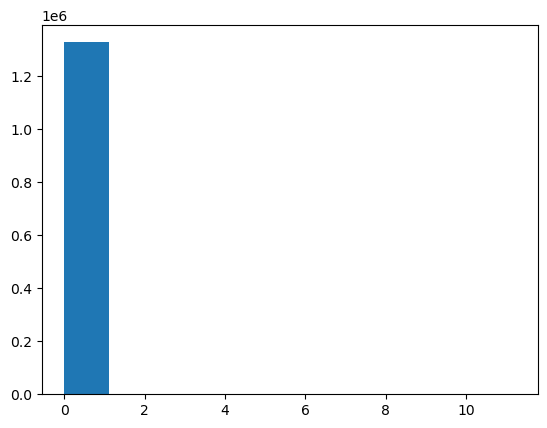

In [452]:
plt.hist(df_previous_application_raw['ratio_AMT_DOWN_PAYMENT_credit'])

In [453]:
df_previous_application_raw['ratio_AMT_ANNUITY_credit'] = df_previous_application_raw['AMT_ANNUITY'] / df_previous_application_raw['AMT_CREDIT']


(array([5.60341e+05, 5.36605e+05, 1.84705e+05, 1.53480e+04, 8.90000e+01,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0.  , 0.09, 0.18, 0.27, 0.36, 0.45, 0.54, 0.63, 0.72, 0.81, 0.9 ]),
 <BarContainer object of 10 artists>)

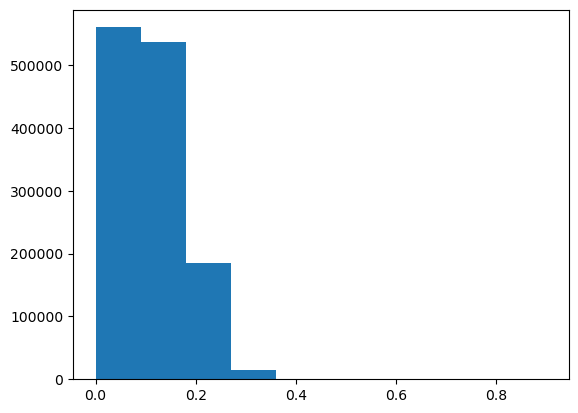

In [454]:
plt.hist(df_previous_application_raw['ratio_AMT_ANNUITY_credit'])

In [455]:
df_previous_application_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   SK_ID_PREV                     1670214 non-null  int64  
 1   SK_ID_CURR                     1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE             1670214 non-null  object 
 3   AMT_ANNUITY                    1632149 non-null  float64
 4   AMT_APPLICATION                1670214 non-null  float64
 5   AMT_CREDIT                     1670213 non-null  float64
 6   AMT_DOWN_PAYMENT               1664758 non-null  float64
 7   AMT_GOODS_PRICE                1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START     1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START        1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY         1670214 non-null  int64  
 12  RATE_DOWN_PAYM

In [456]:
df_previous_application_raw.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,ratio_AMT_DOWN_PAYMENT_credit,ratio_AMT_ANNUITY_credit
count,1.670214e+06,1.670214e+06,1.632149e+06,1.670214e+06,1.670213e+06,1.664758e+06,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,1.329700e+06,1.297091e+06
mean,1.923089e+06,2.783572e+05,1.269578e+04,1.752339e+05,1.961140e+05,3.115328e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570,5.633730e-02,1.024075e-01
std,5.325980e+05,1.028148e+05,1.467036e+04,2.927798e+05,3.185746e+05,1.465475e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,7.127443e+03,1.456729e+01,88916.115833,72444.869708,106857.034789,149647.415123,153303.516729,0.471134,1.458983e-01,5.717195e-02
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000,-1.375327e-05,0.000000e+00
25%,1.461857e+06,1.893290e+05,2.924235e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000,0.000000e+00,5.000000e-02
50%,1.923110e+06,2.787145e+05,8.581455e+03,7.104600e+04,8.054100e+04,0.000000e+00,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000,0.000000e+00,9.902699e-02
75%,2.384280e+06,3.675140e+05,1.710540e+04,1.803600e+05,2.164185e+05,0.000000e+00,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000,1.011018e-01,1.215901e-01
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000,1.122449e+01,9.000000e-01


## New Var 'NAME_CONTRACT_STATUS'

In [457]:
df_previous_application_raw.NAME_CONTRACT_STATUS.value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [458]:
df_previous_application_raw['NAME_CONTRACT_STATUS_code'] = df_previous_application_raw['NAME_CONTRACT_STATUS'].apply(lambda x: ft_contract_status_num(x))
df_previous_application_raw['NAME_CONTRACT_STATUS_code']


0          1.0
1          1.0
2          1.0
3          1.0
4          0.0
          ... 
1670209    1.0
1670210    1.0
1670211    1.0
1670212    1.0
1670213    1.0
Name: NAME_CONTRACT_STATUS_code, Length: 1670214, dtype: float64

In [459]:
df_previous_application_raw.NAME_CONTRACT_TYPE.value_counts()[0]

747553

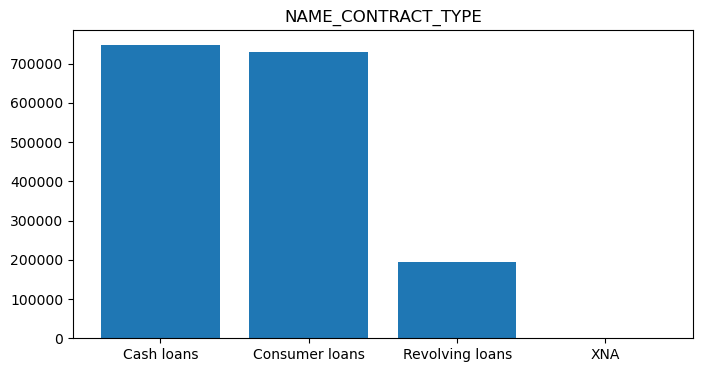

In [460]:
mycat = 'NAME_CONTRACT_TYPE'
data_p = df_previous_application_raw[mycat]
names = list(data_p.value_counts().index)
values = list(data_p.value_counts())
plt.figure(figsize=(8,4))
plt.title(mycat)
g = plt.bar(names, values)

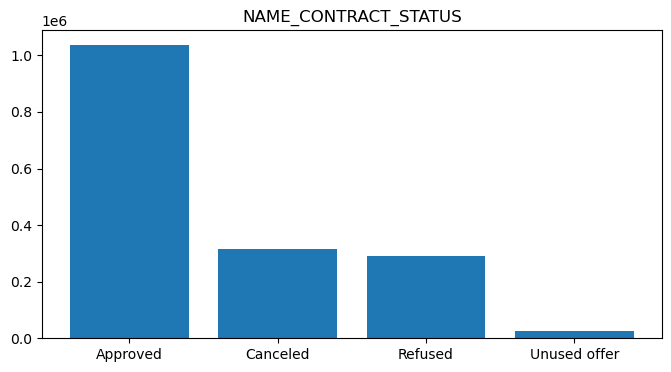

In [461]:
mycat = 'NAME_CONTRACT_STATUS'
data_p = df_previous_application_raw[mycat]
names = list(data_p.value_counts().index)
values = list(data_p.value_counts())
plt.figure(figsize=(8,4))
plt.title(mycat)
g = plt.bar(names, values)

## Analyse graphique

In [462]:
data_p.value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

[0.790285973672265, 0.07107731880768649]


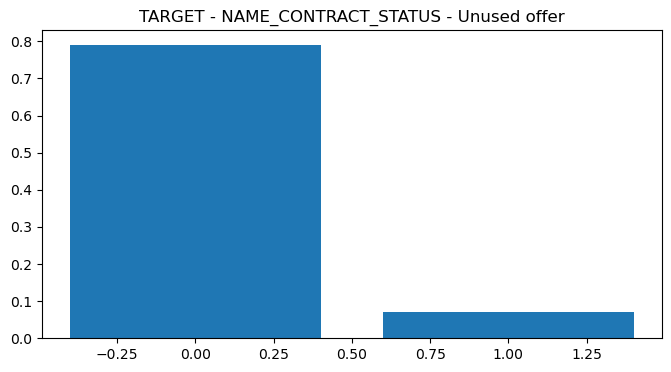

In [463]:
select_value = 'Unused offer'
select_col = 'NAME_CONTRACT_STATUS'
mycat = 'TARGET'
df_prev_select = df_previous_application_raw[df_previous_application_raw[select_col] == select_value].copy(deep=True)
df_result_select = pd.merge(df_prev_select, df_application_train_raw[['SK_ID_CURR', 'TARGET']], how="left", on=["SK_ID_CURR"])
# print(df_result_select.describe())
data_p = df_result_select[mycat]
names = list(data_p.value_counts().index)
values = list(data_p.value_counts()/data_p.shape[0])
plt.figure(figsize=(8,4))
plt.title(mycat + " - " + select_col + " - " + select_value)
print(values)
g = plt.bar(names, values)

[0.7449473474562072, 0.07524050088676304]


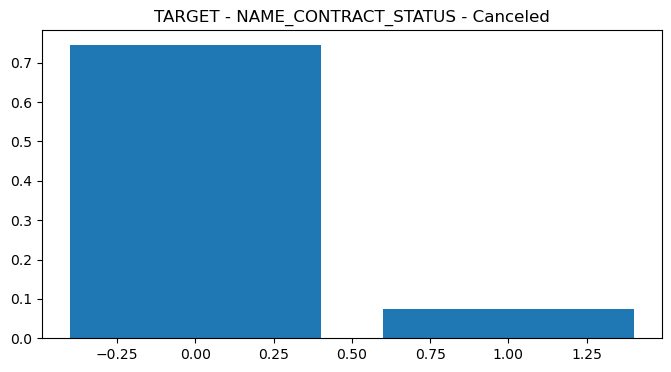

In [464]:
select_value = 'Canceled'
select_col = 'NAME_CONTRACT_STATUS'
mycat = 'TARGET'
df_prev_select = df_previous_application_raw[df_previous_application_raw[select_col] == select_value].copy(deep=True)
df_result_select = pd.merge(df_prev_select, df_application_train_raw[['SK_ID_CURR', 'TARGET']], how="left", on=["SK_ID_CURR"])
# print(df_result_select.describe())
data_p = df_result_select[mycat]
names = list(data_p.value_counts().index)
values = list(data_p.value_counts()/data_p.shape[0])
plt.figure(figsize=(8,4))
plt.title(mycat + " - " + select_col + " - " + select_value)
print(values)
g = plt.bar(names, values)

XAP       1353093
HC         175231
LIMIT       55680
SCO         37467
CLIENT      26436
SCOFR       12811
XNA          5244
VERIF        3535
SYSTEM        717
Name: CODE_REJECT_REASON, dtype: int64

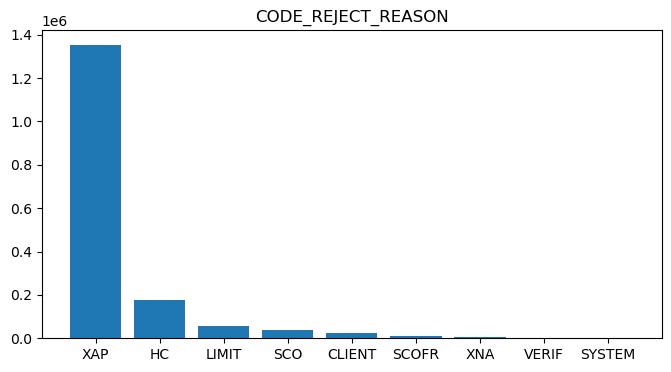

In [465]:
mycat = 'CODE_REJECT_REASON'
data_p = df_previous_application_raw[mycat]
names = list(data_p.value_counts().index)
values = list(data_p.value_counts())
plt.figure(figsize=(8,4))
plt.title(mycat)
g = plt.bar(names, values)
data_p.value_counts()

XAP                                 922661
XNA                                 677918
Repairs                              23765
Other                                15608
Urgent needs                          8412
Buying a used car                     2888
Building a house or an annex          2693
Everyday expenses                     2416
Medicine                              2174
Payments on other loans               1931
Education                             1573
Journey                               1239
Purchase of electronic equipment      1061
Buying a new car                      1012
Wedding / gift / holiday               962
Buying a home                          865
Car repairs                            797
Furniture                              749
Buying a holiday home / land           533
Business development                   426
Gasification / water supply            300
Buying a garage                        136
Hobby                                   55
Money for a

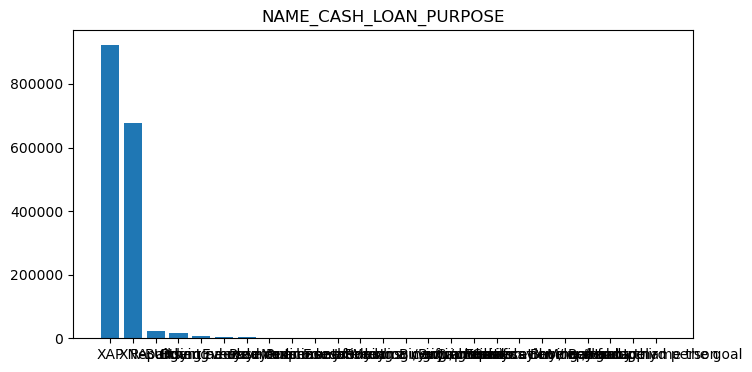

In [466]:

mycat = 'NAME_CASH_LOAN_PURPOSE'
data_p = df_previous_application_raw[mycat]
names = list(data_p.value_counts().index)
values = list(data_p.value_counts())
plt.figure(figsize=(8,4))
plt.title(mycat)
g = plt.bar(names, values)
data_p.value_counts()

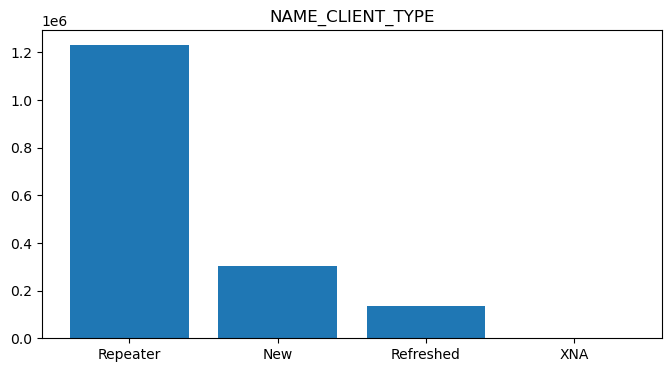

In [467]:

mycat = 'NAME_CLIENT_TYPE'
data_p = df_previous_application_raw[mycat]
names = list(data_p.value_counts().index)
values = list(data_p.value_counts())
plt.figure(figsize=(8,4))
plt.title(mycat)
g = plt.bar(names, values)


XNA                         950809
Mobile                      224708
Consumer Electronics        121576
Computers                   105769
Audio/Video                  99441
Furniture                    53656
Photo / Cinema Equipment     25021
Construction Materials       24995
Clothing and Accessories     23554
Auto Accessories              7381
Jewelry                       6290
Homewares                     5023
Medical Supplies              3843
Vehicles                      3370
Sport and Leisure             2981
Gardening                     2668
Other                         2554
Office Appliances             2333
Tourism                       1659
Medicine                      1550
Direct Sales                   446
Fitness                        209
Additional Service             128
Education                      107
Weapon                          77
Insurance                       64
House Construction               1
Animals                          1
Name: NAME_GOODS_CAT

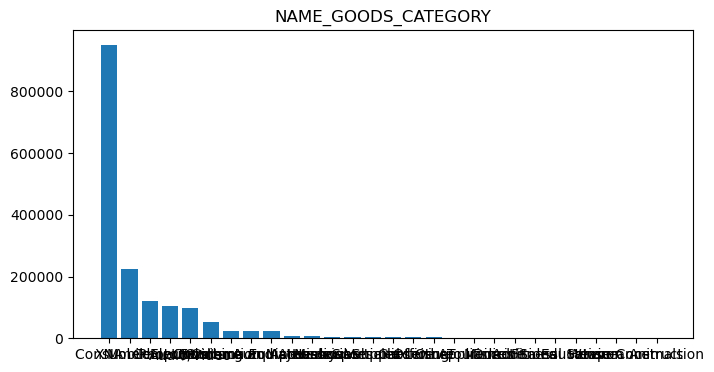

In [468]:

mycat = 'NAME_GOODS_CATEGORY'
data_p = df_previous_application_raw[mycat]
names = list(data_p.value_counts().index)
values = list(data_p.value_counts())
plt.figure(figsize=(8,4))
plt.title(mycat)
g = plt.bar(names, values)
data_p.value_counts()

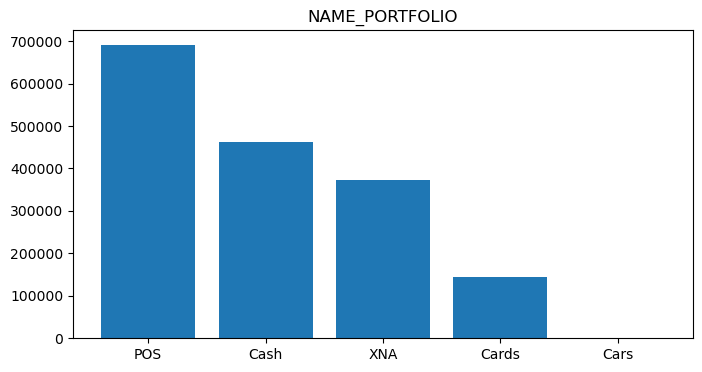

In [469]:
mycat = 'NAME_PORTFOLIO'
data_p = df_previous_application_raw[mycat]
names = list(data_p.value_counts().index)
values = list(data_p.value_counts())
plt.figure(figsize=(8,4))
plt.title(mycat)
g = plt.bar(names, values)

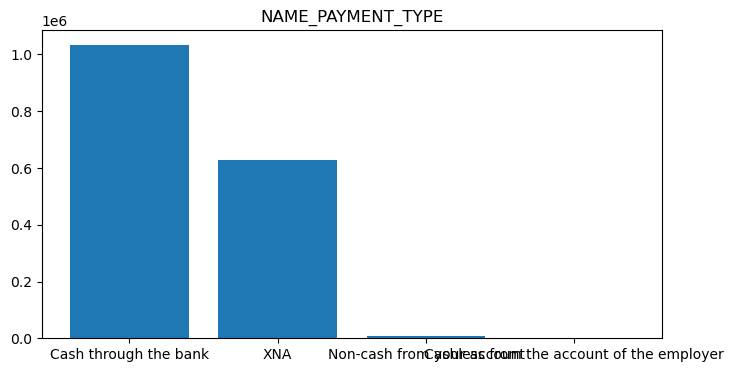

In [470]:
mycat = 'NAME_PAYMENT_TYPE'
data_p = df_previous_application_raw[mycat]
names = list(data_p.value_counts().index)
values = list(data_p.value_counts())
plt.figure(figsize=(8,4))
plt.title(mycat)
g = plt.bar(names, values)

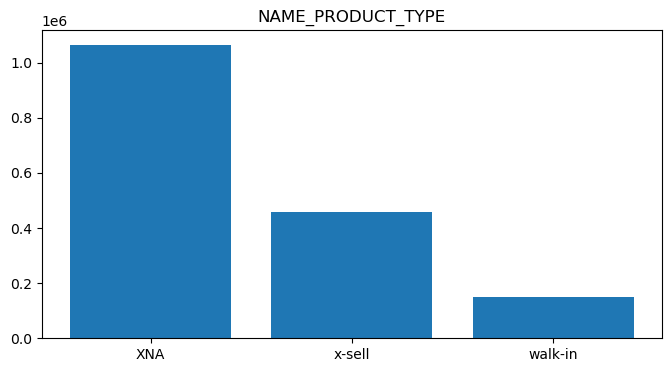

In [471]:
mycat = 'NAME_PRODUCT_TYPE'
data_p = df_previous_application_raw[mycat]
names = list(data_p.value_counts().index)
values = list(data_p.value_counts())
plt.figure(figsize=(8,4))
plt.title(mycat)
g = plt.bar(names, values)

Credit and cash offices       719968
Country-wide                  494690
Stone                         212083
Regional / Local              108528
Contact center                 71297
AP+ (Cash loan)                57046
Channel of corporate sales      6150
Car dealer                       452
Name: CHANNEL_TYPE, dtype: int64

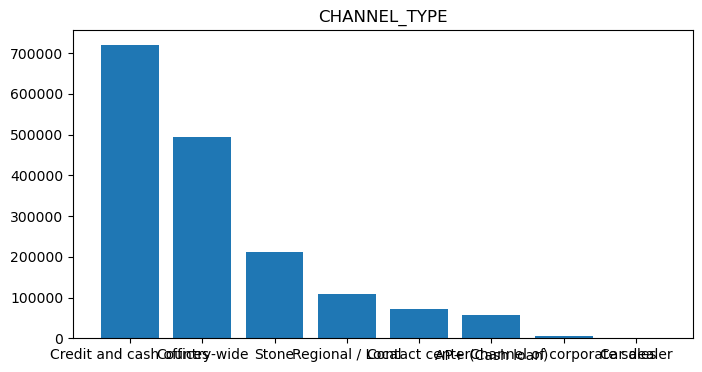

In [472]:
mycat = 'CHANNEL_TYPE'
data_p = df_previous_application_raw[mycat]
names = list(data_p.value_counts().index)
values = list(data_p.value_counts())
plt.figure(figsize=(8,4))
plt.title(mycat)
g = plt.bar(names, values)
data_p.value_counts()

XNA                     855720
Consumer electronics    398265
Connectivity            276029
Furniture                57849
Construction             29781
Clothing                 23949
Industry                 19194
Auto technology           4990
Jewelry                   2709
MLM partners              1215
Tourism                    513
Name: NAME_SELLER_INDUSTRY, dtype: int64

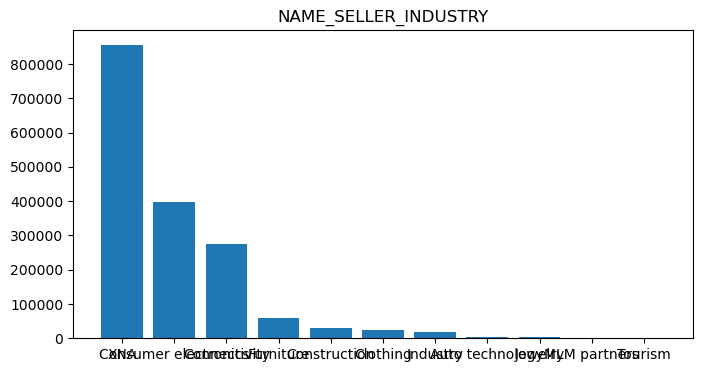

In [473]:
mycat = 'NAME_SELLER_INDUSTRY'
data_p = df_previous_application_raw[mycat]
names = list(data_p.value_counts().index)
values = list(data_p.value_counts())
plt.figure(figsize=(8,4))
plt.title(mycat)
g = plt.bar(names, values)
data_p.value_counts()

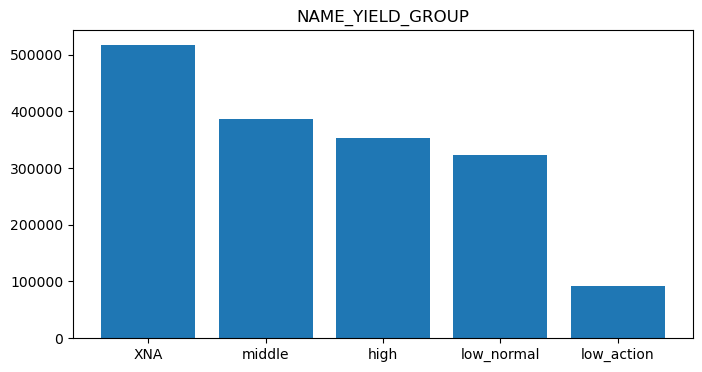

In [474]:
mycat = 'NAME_YIELD_GROUP'
data_p = df_previous_application_raw[mycat]
names = list(data_p.value_counts().index)
values = list(data_p.value_counts())
plt.figure(figsize=(8,4))
plt.title(mycat)
g = plt.bar(names, values)

Cash                              285990
POS household with interest       263622
POS mobile with interest          220670
Cash X-Sell: middle               143883
Cash X-Sell: low                  130248
Card Street                       112582
POS industry with interest         98833
POS household without interest     82908
Card X-Sell                        80582
Cash Street: high                  59639
Cash X-Sell: high                  59301
Cash Street: middle                34658
Cash Street: low                   33834
POS mobile without interest        24082
POS other with interest            23879
POS industry without interest      12602
POS others without interest         2555
Name: PRODUCT_COMBINATION, dtype: int64

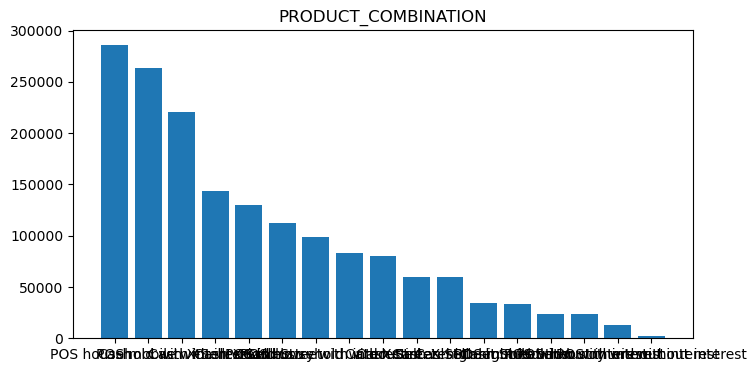

In [475]:
mycat = 'PRODUCT_COMBINATION'
data_p = df_previous_application_raw[mycat]
names = list(data_p.value_counts().index)
values = list(data_p.value_counts())
plt.figure(figsize=(8,4))
plt.title(mycat)
g = plt.bar(names, values)
data_p.value_counts()

<BarContainer object of 17 artists>

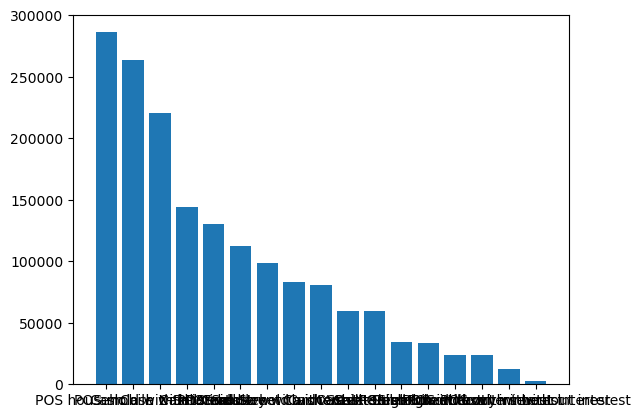

In [476]:
plt.bar(names, values)

In [477]:
df_previous_application_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 38 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   SK_ID_PREV                     1670214 non-null  int64  
 1   SK_ID_CURR                     1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE             1670214 non-null  object 
 3   AMT_ANNUITY                    1632149 non-null  float64
 4   AMT_APPLICATION                1670214 non-null  float64
 5   AMT_CREDIT                     1670213 non-null  float64
 6   AMT_DOWN_PAYMENT               1664758 non-null  float64
 7   AMT_GOODS_PRICE                1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START     1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START        1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY         1670214 non-null  int64  
 12  RATE_DOWN_PAYM

In [478]:
38+143

181

## Processing previous_application - valeurs moyennes

In [479]:
prev_cat_features = [
    f_ for f_ in df_previous_application_raw.columns if df_previous_application_raw[f_].dtype == 'object'
]

In [480]:
prev_cat_features, len(prev_cat_features)

(['NAME_CONTRACT_TYPE',
  'WEEKDAY_APPR_PROCESS_START',
  'FLAG_LAST_APPL_PER_CONTRACT',
  'NAME_CASH_LOAN_PURPOSE',
  'NAME_CONTRACT_STATUS',
  'NAME_PAYMENT_TYPE',
  'CODE_REJECT_REASON',
  'NAME_TYPE_SUITE',
  'NAME_CLIENT_TYPE',
  'NAME_GOODS_CATEGORY',
  'NAME_PORTFOLIO',
  'NAME_PRODUCT_TYPE',
  'CHANNEL_TYPE',
  'NAME_SELLER_INDUSTRY',
  'NAME_YIELD_GROUP',
  'PRODUCT_COMBINATION'],
 16)

In [481]:
df_previous_application_raw

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,ratio_AMT_DOWN_PAYMENT_credit,ratio_AMT_ANNUITY_credit,NAME_CONTRACT_STATUS_code
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0.000000,0.100929,1.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,0.0,607500.0,THURSDAY,11,...,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0.000000,0.037060,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,0.0,112500.0,TUESDAY,11,...,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,0.000000,0.110380,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,0.0,450000.0,MONDAY,7,...,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,0.000000,0.099920,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,0.0,337500.0,THURSDAY,9,...,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.079010,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0,0.000000,0.047220,1.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0,0.454959,0.103000,1.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0,0.102664,0.112373,1.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,0.0,180000.0,WEDNESDAY,9,...,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0,0.000000,0.098090,1.0


In [482]:
df_previous_application_raw.NAME_CONTRACT_STATUS_code.value_counts()

1.0    1036781
0.6     342755
0.0     290678
Name: NAME_CONTRACT_STATUS_code, dtype: int64

In [483]:
df_previous_application_raw.shape

(1670214, 38)

In [484]:
prev_dum = pd.DataFrame()
for f_ in prev_cat_features:
    prev_dum = pd.concat([prev_dum, pd.get_dummies(df_previous_application_raw[f_], prefix=f_).astype(np.uint8)], axis=1)
prev_dum

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Consumer loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_XNA,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1670210,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1670211,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1670212,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [485]:
df_previous_application_raw = pd.concat([df_previous_application_raw, prev_dum], axis=1)


In [486]:
# del prev_dum
# import gc
# gc.collect()

In [487]:
df_previous_application_raw.shape

(1670214, 181)

In [488]:
df_previous_application_raw[df_previous_application_raw.SK_ID_CURR == 456255]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
214743,1743609,456255,Consumer loans,11090.835,102037.5,112815.0,0.0,102037.5,THURSDAY,18,...,0,0,0,0,1,0,0,0,0,0
453227,1359084,456255,Consumer loans,11314.170,82404.0,93298.5,9000.0,82404.0,SUNDAY,14,...,0,0,0,0,0,0,1,0,0,0
596623,1179690,456255,Cash loans,28873.170,450000.0,491580.0,0.0,450000.0,TUESDAY,13,...,0,1,0,0,0,0,0,0,0,0
608510,2073384,456255,Cash loans,16400.610,229500.0,254340.0,0.0,229500.0,THURSDAY,12,...,0,1,0,0,0,0,0,0,0,0
729432,1708056,456255,Revolving loans,2250.000,45000.0,45000.0,0.0,45000.0,SUNDAY,14,...,0,0,0,0,0,0,0,0,0,0
814647,1296007,456255,Cash loans,30737.655,765000.0,1067940.0,0.0,765000.0,FRIDAY,14,...,0,0,0,0,0,0,0,0,0,0
1383554,2631384,456255,Cash loans,54022.140,1170000.0,1271929.5,0.0,1170000.0,FRIDAY,14,...,1,0,0,0,0,0,0,0,0,0
1411592,2729207,456255,Consumer loans,11514.555,58225.5,58545.0,5823.0,58225.5,FRIDAY,18,...,0,0,0,0,0,0,1,0,0,0


In [489]:
nb_prev_per_curr = df_previous_application_raw[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
nb_prev_per_curr

,SK_ID_PREV
SK_ID_CURR,
100001,1
100002,1
100003,3
100004,1
100005,2
...,...
456251,1
456252,1
456253,2


In [490]:
df_previous_application_raw['SK_ID_PREV'] = df_previous_application_raw['SK_ID_CURR'].map(nb_prev_per_curr['SK_ID_PREV'])


In [491]:
df_previous_application_raw

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
0,3,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,0,0,0,0,0,0,1,0,0,0
1,6,108129,Cash loans,25188.615,607500.0,679671.0,0.0,607500.0,THURSDAY,11,...,1,0,0,0,0,0,0,0,0,0
2,4,122040,Cash loans,15060.735,112500.0,136444.5,0.0,112500.0,TUESDAY,11,...,0,0,0,0,0,0,0,0,0,0
3,23,176158,Cash loans,47041.335,450000.0,470790.0,0.0,450000.0,MONDAY,7,...,0,1,0,0,0,0,0,0,0,0
4,25,202054,Cash loans,31924.395,337500.0,404055.0,0.0,337500.0,THURSDAY,9,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,5,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,0,0,0,0,1,0,0,0,0,0
1670210,7,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,0,0,0,0,1,0,0,0,0,0
1670211,3,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,0,0,1,0,0,0,0,0,0,0
1670212,9,400317,Cash loans,18821.520,180000.0,191880.0,0.0,180000.0,WEDNESDAY,9,...,1,0,0,0,0,0,0,0,0,0


In [492]:
df_previous_application_raw[df_previous_application_raw.SK_ID_CURR == 456255]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
214743,8,456255,Consumer loans,11090.835,102037.5,112815.0,0.0,102037.5,THURSDAY,18,...,0,0,0,0,1,0,0,0,0,0
453227,8,456255,Consumer loans,11314.170,82404.0,93298.5,9000.0,82404.0,SUNDAY,14,...,0,0,0,0,0,0,1,0,0,0
596623,8,456255,Cash loans,28873.170,450000.0,491580.0,0.0,450000.0,TUESDAY,13,...,0,1,0,0,0,0,0,0,0,0
608510,8,456255,Cash loans,16400.610,229500.0,254340.0,0.0,229500.0,THURSDAY,12,...,0,1,0,0,0,0,0,0,0,0
729432,8,456255,Revolving loans,2250.000,45000.0,45000.0,0.0,45000.0,SUNDAY,14,...,0,0,0,0,0,0,0,0,0,0
814647,8,456255,Cash loans,30737.655,765000.0,1067940.0,0.0,765000.0,FRIDAY,14,...,0,0,0,0,0,0,0,0,0,0
1383554,8,456255,Cash loans,54022.140,1170000.0,1271929.5,0.0,1170000.0,FRIDAY,14,...,1,0,0,0,0,0,0,0,0,0
1411592,8,456255,Consumer loans,11514.555,58225.5,58545.0,5823.0,58225.5,FRIDAY,18,...,0,0,0,0,0,0,1,0,0,0


### Calcul valeurs moyennes previous_application - MEAN

In [493]:
df_previous_application_avg = df_previous_application_raw.groupby('SK_ID_CURR').mean()
# print(df_previous_application_avg.head())
df_previous_application_avg.head()
# del prev
# gc.collect()

,SK_ID_PREV,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,DAYS_DECISION,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1.0,3951.000,24835.50,23787.00,2520.0,24835.5,13.000000,1.0,0.104326,-1740.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
100002,1.0,9251.775,179055.00,179055.00,0.0,179055.0,9.000000,1.0,0.000000,-606.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0
100003,3.0,56553.990,435436.50,484191.00,2295.0,435436.5,14.666667,1.0,0.050030,-1305.0,...,0.333333,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0
100004,1.0,5357.250,24282.00,20106.00,4860.0,24282.0,5.000000,1.0,0.212008,-815.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
100005,2.0,2406.600,22308.75,20076.75,2232.0,44617.5,10.500000,1.0,0.108964,-536.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.5,0.0,0.0,0.0


In [494]:
df_previous_application_avg

,SK_ID_PREV,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,DAYS_DECISION,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1.0,3951.000000,24835.500,23787.00,2520.000,24835.500,13.000000,1.0,0.104326,-1740.000,...,0.000000,0.00,0.000000,0.0,0.000000,0.0,1.00,0.0,0.0,0.0
100002,1.0,9251.775000,179055.000,179055.00,0.000,179055.000,9.000000,1.0,0.000000,-606.000,...,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.00,0.0,1.0,0.0
100003,3.0,56553.990000,435436.500,484191.00,2295.000,435436.500,14.666667,1.0,0.050030,-1305.000,...,0.333333,0.00,0.333333,0.0,0.333333,0.0,0.00,0.0,0.0,0.0
100004,1.0,5357.250000,24282.000,20106.00,4860.000,24282.000,5.000000,1.0,0.212008,-815.000,...,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.00,1.0,0.0,0.0
100005,2.0,2406.600000,22308.750,20076.75,2232.000,44617.500,10.500000,1.0,0.108964,-536.000,...,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.50,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,1.0,6605.910000,40455.000,40455.00,0.000,40455.000,17.000000,1.0,0.000000,-273.000,...,0.000000,0.00,0.000000,0.0,0.000000,0.0,1.00,0.0,0.0,0.0
456252,1.0,10074.465000,57595.500,56821.50,3456.000,57595.500,10.000000,1.0,0.062443,-2497.000,...,0.000000,0.00,0.000000,1.0,0.000000,0.0,0.00,0.0,0.0,0.0
456253,2.0,4770.405000,24162.750,20625.75,4403.250,24162.750,11.500000,1.0,0.214316,-2380.000,...,0.000000,0.00,0.000000,0.0,0.000000,0.0,1.00,0.0,0.0,0.0


### Calcul valeurs mediannes previous_application - MEDIAN (alternative)

In [495]:
df_previous_application_med = df_previous_application_raw.groupby('SK_ID_CURR').median()
# print(df_previous_application_med.head())
df_previous_application_med.head()
# del prev
# gc.collect()

,SK_ID_PREV,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,DAYS_DECISION,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1.0,3951.000,24835.50,23787.00,2520.0,24835.5,13.0,1.0,0.104326,-1740.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
100002,1.0,9251.775,179055.00,179055.00,0.0,179055.0,9.0,1.0,0.000000,-606.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100003,3.0,64567.665,337500.00,348637.50,0.0,337500.0,15.0,1.0,0.050030,-828.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100004,1.0,5357.250,24282.00,20106.00,4860.0,24282.0,5.0,1.0,0.212008,-815.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
100005,2.0,2406.600,22308.75,20076.75,2232.0,44617.5,10.5,1.0,0.108964,-536.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0


In [496]:
df_previous_application_med

,SK_ID_PREV,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,DAYS_DECISION,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1.0,3951.0000,24835.50,23787.00,2520.00,24835.50,13.0,1.0,0.104326,-1740.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
100002,1.0,9251.7750,179055.00,179055.00,0.00,179055.00,9.0,1.0,0.000000,-606.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100003,3.0,64567.6650,337500.00,348637.50,0.00,337500.00,15.0,1.0,0.050030,-828.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100004,1.0,5357.2500,24282.00,20106.00,4860.00,24282.00,5.0,1.0,0.212008,-815.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
100005,2.0,2406.6000,22308.75,20076.75,2232.00,44617.50,10.5,1.0,0.108964,-536.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456251,1.0,6605.9100,40455.00,40455.00,0.00,40455.00,17.0,1.0,0.000000,-273.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
456252,1.0,10074.4650,57595.50,56821.50,3456.00,57595.50,10.0,1.0,0.062443,-2497.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
456253,2.0,4770.4050,24162.75,20625.75,4403.25,24162.75,11.5,1.0,0.214316,-2380.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [497]:
df_previous_application_avg[['SK_ID_PREV','AMT_CREDIT','NAME_CONTRACT_STATUS_code']]

,SK_ID_PREV,AMT_CREDIT,NAME_CONTRACT_STATUS_code
SK_ID_CURR,,,
100001,1.0,23787.00,1.00
100002,1.0,179055.00,1.00
100003,3.0,484191.00,1.00
100004,1.0,20106.00,1.00
100005,2.0,20076.75,0.80
...,...,...,...
456251,1.0,40455.00,1.00
456252,1.0,56821.50,1.00
456253,2.0,20625.75,1.00


## 3c - credit_card_balance.csv

In [498]:
df_credit_card_balance_raw = \
    pd.read_csv('./data/credit_card_balance.csv',
                low_memory=False)

In [499]:
print("Dataset light pour graphs et model cleaned : %d colonnes & %d lignes"
      % (df_credit_card_balance_raw.shape[1],
         df_credit_card_balance_raw.shape[0]))

Dataset light pour graphs et model cleaned : 23 colonnes & 3840312 lignes


In [500]:
df_credit_card_balance_raw.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')

In [501]:
df_credit_card_balance_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [502]:
df_credit_card_balance_raw.NAME_CONTRACT_STATUS.value_counts()

Active           3698436
Completed         128918
Signed             11058
Demand              1365
Sent proposal        513
Refused               17
Approved               5
Name: NAME_CONTRACT_STATUS, dtype: int64

In [503]:
df_credit_card_balance_raw

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [504]:
# print('Reading CC balance')
# cc_bal = pd.read_csv('./data/credit_card_balance.csv')

# print('Go to dummies')
df_credit_card_balance_raw = pd.concat([df_credit_card_balance_raw, pd.get_dummies(df_credit_card_balance_raw['NAME_CONTRACT_STATUS'], prefix='cc_bal_status_')], axis=1)
df_credit_card_balance_raw


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,cc_bal_status__Active,cc_bal_status__Approved,cc_bal_status__Completed,cc_bal_status__Demand,cc_bal_status__Refused,cc_bal_status__Sent proposal,cc_bal_status__Signed
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,Active,0,0,1,0,0,0,0,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,Active,0,0,1,0,0,0,0,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,Active,0,0,1,0,0,0,0,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,Active,0,0,1,0,0,0,0,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,Active,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,Active,0,0,1,0,0,0,0,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,Active,0,0,1,0,0,0,0,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,Active,0,0,1,0,0,0,0,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,Active,0,0,1,0,0,0,0,0,0


In [505]:
nb_prevs = df_credit_card_balance_raw[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
nb_prevs

,SK_ID_PREV
SK_ID_CURR,
100006,6
100011,74
100013,96
100021,17
100023,8
...,...
456244,41
456246,8
456247,95


In [506]:
df_credit_card_balance_raw['SK_ID_PREV'] = df_credit_card_balance_raw['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
df_credit_card_balance_raw

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,cc_bal_status__Active,cc_bal_status__Approved,cc_bal_status__Completed,cc_bal_status__Demand,cc_bal_status__Refused,cc_bal_status__Sent proposal,cc_bal_status__Signed
0,47,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,Active,0,0,1,0,0,0,0,0,0
1,96,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,Active,0,0,1,0,0,0,0,0,0
2,37,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,Active,0,0,1,0,0,0,0,0,0
3,15,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,Active,0,0,1,0,0,0,0,0,0
4,96,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,Active,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,10,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,Active,0,0,1,0,0,0,0,0,0
3840308,84,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,Active,0,0,1,0,0,0,0,0,0
3840309,28,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,Active,0,0,1,0,0,0,0,0,0
3840310,14,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,Active,0,0,1,0,0,0,0,0,0


### Valeurs moyennes - MEAN

In [507]:
# print('Compute average')
avg_cc_bal = df_credit_card_balance_raw.groupby('SK_ID_CURR').mean()
avg_cc_bal

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,cc_bal_status__Active,cc_bal_status__Approved,cc_bal_status__Completed,cc_bal_status__Demand,cc_bal_status__Refused,cc_bal_status__Sent proposal,cc_bal_status__Signed
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,6.0,-3.5,0.000000,270000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100011,74.0,-38.5,54482.111149,164189.189189,2432.432432,2432.432432,0.0,0.000000,3956.221849,4843.064189,...,25.767123,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100013,96.0,-48.5,18159.919219,131718.750000,6350.000000,5953.125000,0.0,0.000000,1454.539551,7168.346250,...,18.719101,0.010417,0.010417,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100021,17.0,-10.0,0.000000,675000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,0.411765,0.0,0.588235,0.0,0.0,0.0,0.0
100023,8.0,-7.5,0.000000,135000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,41.0,-21.0,131834.730732,296341.463415,24475.609756,26842.388049,0.0,2363.015854,6514.200000,32720.544878,...,13.600000,0.000000,0.000000,0.878049,0.0,0.121951,0.0,0.0,0.0,0.0
456246,8.0,-5.5,13136.731875,135000.000000,0.000000,15199.256250,0.0,15199.256250,1439.150625,18778.275000,...,3.500000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
456247,95.0,-49.0,23216.396211,144000.000000,2136.315789,2149.506474,0.0,13.190684,1414.704789,4883.755263,...,26.494737,0.031579,0.021053,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0


### Valeurs mediannes - MEDIAN

In [508]:
# print('Compute average')
med_cc_bal = df_credit_card_balance_raw.groupby('SK_ID_CURR').median()
med_cc_bal

,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,...,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,cc_bal_status__Active,cc_bal_status__Approved,cc_bal_status__Completed,cc_bal_status__Demand,cc_bal_status__Refused,cc_bal_status__Sent proposal,cc_bal_status__Signed
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,6.0,-3.5,0.0000,270000.0,NaN,0.000,NaN,NaN,0.0000,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
100011,74.0,-38.5,0.0000,180000.0,0.0,0.000,0.0,0.000,0.0000,563.355,...,33.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
100013,96.0,-48.5,0.0000,157500.0,0.0,0.000,0.0,0.000,0.0000,274.320,...,22.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
100021,17.0,-10.0,0.0000,675000.0,NaN,0.000,NaN,NaN,0.0000,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
100023,8.0,-7.5,0.0000,135000.0,NaN,0.000,NaN,NaN,0.0000,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,41.0,-21.0,0.0000,450000.0,0.0,0.000,0.0,0.000,0.0000,154.260,...,17.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
456246,8.0,-5.5,753.4125,135000.0,0.0,526.275,0.0,526.275,2250.0000,18000.000,...,3.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
456247,95.0,-49.0,0.0000,180000.0,0.0,0.000,0.0,0.000,0.0000,520.605,...,32.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [509]:
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]

In [510]:
avg_cc_bal

,cc_bal_SK_ID_PREV,cc_bal_MONTHS_BALANCE,cc_bal_AMT_BALANCE,cc_bal_AMT_CREDIT_LIMIT_ACTUAL,cc_bal_AMT_DRAWINGS_ATM_CURRENT,cc_bal_AMT_DRAWINGS_CURRENT,cc_bal_AMT_DRAWINGS_OTHER_CURRENT,cc_bal_AMT_DRAWINGS_POS_CURRENT,cc_bal_AMT_INST_MIN_REGULARITY,cc_bal_AMT_PAYMENT_CURRENT,...,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF,cc_bal_cc_bal_status__Active,cc_bal_cc_bal_status__Approved,cc_bal_cc_bal_status__Completed,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,6.0,-3.5,0.000000,270000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100011,74.0,-38.5,54482.111149,164189.189189,2432.432432,2432.432432,0.0,0.000000,3956.221849,4843.064189,...,25.767123,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100013,96.0,-48.5,18159.919219,131718.750000,6350.000000,5953.125000,0.0,0.000000,1454.539551,7168.346250,...,18.719101,0.010417,0.010417,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
100021,17.0,-10.0,0.000000,675000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,0.411765,0.0,0.588235,0.0,0.0,0.0,0.0
100023,8.0,-7.5,0.000000,135000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,41.0,-21.0,131834.730732,296341.463415,24475.609756,26842.388049,0.0,2363.015854,6514.200000,32720.544878,...,13.600000,0.000000,0.000000,0.878049,0.0,0.121951,0.0,0.0,0.0,0.0
456246,8.0,-5.5,13136.731875,135000.000000,0.000000,15199.256250,0.0,15199.256250,1439.150625,18778.275000,...,3.500000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0
456247,95.0,-49.0,23216.396211,144000.000000,2136.315789,2149.506474,0.0,13.190684,1414.704789,4883.755263,...,26.494737,0.031579,0.021053,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [511]:
med_cc_bal.columns = ['cc_bal_' + f_ for f_ in med_cc_bal.columns]

In [512]:
med_cc_bal

,cc_bal_SK_ID_PREV,cc_bal_MONTHS_BALANCE,cc_bal_AMT_BALANCE,cc_bal_AMT_CREDIT_LIMIT_ACTUAL,cc_bal_AMT_DRAWINGS_ATM_CURRENT,cc_bal_AMT_DRAWINGS_CURRENT,cc_bal_AMT_DRAWINGS_OTHER_CURRENT,cc_bal_AMT_DRAWINGS_POS_CURRENT,cc_bal_AMT_INST_MIN_REGULARITY,cc_bal_AMT_PAYMENT_CURRENT,...,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF,cc_bal_cc_bal_status__Active,cc_bal_cc_bal_status__Approved,cc_bal_cc_bal_status__Completed,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,6.0,-3.5,0.0000,270000.0,NaN,0.000,NaN,NaN,0.0000,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
100011,74.0,-38.5,0.0000,180000.0,0.0,0.000,0.0,0.000,0.0000,563.355,...,33.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
100013,96.0,-48.5,0.0000,157500.0,0.0,0.000,0.0,0.000,0.0000,274.320,...,22.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
100021,17.0,-10.0,0.0000,675000.0,NaN,0.000,NaN,NaN,0.0000,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
100023,8.0,-7.5,0.0000,135000.0,NaN,0.000,NaN,NaN,0.0000,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,41.0,-21.0,0.0000,450000.0,0.0,0.000,0.0,0.000,0.0000,154.260,...,17.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
456246,8.0,-5.5,753.4125,135000.0,0.0,526.275,0.0,526.275,2250.0000,18000.000,...,3.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
456247,95.0,-49.0,0.0000,180000.0,0.0,0.000,0.0,0.000,0.0000,520.605,...,32.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [513]:
# del cc_bal, nb_prevs
# gc.collect()

# D - Merge dataframes

### merge 
### - df_application_train_raw, 
### - df_previous_application (median ou mean)
### - credit card balance (median ou mean)

### df_application_test_raw

In [514]:
is_median_not_mean_val_chosen = False
# df_previous_application_med V.S. df_previous_application_avg

In [515]:
is_credit_card_balance_incorporated = True

In [516]:
if is_median_not_mean_val_chosen:
    # previous_application
    df_application_train_prev_app_raw = df_application_train_raw.merge(right=df_previous_application_med.reset_index(), how='left', on='SK_ID_CURR')
    df_application_test_prev_app_raw = df_application_test_raw.merge(right=df_previous_application_med.reset_index(), how='left', on='SK_ID_CURR')
    if is_credit_card_balance_incorporated:
        #credit card balance
        df_application_train_prev_app_raw = df_application_train_raw.merge(right=med_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
        df_application_test_prev_app_raw = df_application_test_raw.merge(right=med_cc_bal.reset_index(), how='left', on='SK_ID_CURR')    
else:
    # previous_application
    df_application_train_prev_app_raw = df_application_train_raw.merge(right=df_previous_application_avg.reset_index(), how='left', on='SK_ID_CURR')
    df_application_test_prev_app_raw = df_application_test_raw.merge(right=df_previous_application_avg.reset_index(), how='left', on='SK_ID_CURR')
    if is_credit_card_balance_incorporated:
        #credit card balance
        df_application_train_prev_app_raw = df_application_train_raw.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
        df_application_test_prev_app_raw = df_application_test_raw.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
   

In [517]:
df_application_train_prev_app_raw

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF,cc_bal_cc_bal_status__Active,cc_bal_cc_bal_status__Approved,cc_bal_cc_bal_status__Completed,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [518]:
df_application_test_prev_app_raw

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF,cc_bal_cc_bal_status__Active,cc_bal_cc_bal_status__Approved,cc_bal_cc_bal_status__Completed,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,18.719101,0.010417,0.010417,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,19.547619,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [519]:
df_application_train_prev_app_raw.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'cc_bal_CNT_INSTALMENT_MATURE_CUM', 'cc_bal_SK_DPD',
       'cc_bal_SK_DPD_DEF', 'cc_bal_cc_bal_status__Active',
       'cc_bal_cc_bal_status__Approved', 'cc_bal_cc_bal_status__Completed',
       'cc_bal_cc_bal_status__Demand', 'cc_bal_cc_bal_status__Refused',
       'cc_bal_cc_bal_status__Sent proposal', 'cc_bal_cc_bal_status__Signed'],
      dtype='object', length=150)

In [520]:
df_application_train_prev_app_raw.SK_ID_CURR.value_counts()

100401    1
239070    1
243164    1
230874    1
237017    1
         ..
154398    1
148253    1
150300    1
160539    1
100303    1
Name: SK_ID_CURR, Length: 307511, dtype: int64

# Temporary  dataframe

In [521]:
df_train = df_application_train_prev_app_raw.copy(deep=True)
df_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF,cc_bal_cc_bal_status__Active,cc_bal_cc_bal_status__Approved,cc_bal_cc_bal_status__Completed,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [522]:
df_test = df_application_test_prev_app_raw.copy(deep=True)
df_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF,cc_bal_cc_bal_status__Active,cc_bal_cc_bal_status__Approved,cc_bal_cc_bal_status__Completed,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,18.719101,0.010417,0.010417,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,19.547619,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# On ne fait plus le drop nan
### car trop de perte d'information et le modele peut gerer les valeurs NaN

In [523]:
# df_train = df_train.dropna()
# df_train

#### various checks

In [524]:
df_train.NAME_CONTRACT_TYPE.value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [525]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 150 entries, SK_ID_CURR to cc_bal_cc_bal_status__Signed
dtypes: float64(93), int64(41), object(16)
memory usage: 354.3+ MB


In [526]:
# df_train_num = pd.get_dummies(df_train, drop_first=True)
# df_train_num

In [527]:
# df_train_num.info()

In [528]:
# df_train_num.columns

In [529]:
# df_train_num[['PRODUCT_COMBINATION_POS other with interest','PRODUCT_COMBINATION_POS others without interest']]

In [530]:
# X_all = df_train_num.loc[:, (df_train_num.columns != 'TARGET') & (df_train_num.columns != 'SK_ID_CURR')].values

# X_all.shape
# # (1413701, 348)

In [531]:
# y_all = df_train_num['TARGET'].values
# y_all.shape

### Test cat features

In [532]:
data = df_train.copy(deep=True)
test = df_test.copy(deep=True)

In [533]:
categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]
categorical_feats
for f_ in categorical_feats:
    data[f_], indexer = pd.factorize(data[f_])
    test[f_] = indexer.get_indexer(test[f_])

In [534]:
categorical_feats

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [535]:
data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF,cc_bal_cc_bal_status__Active,cc_bal_cc_bal_status__Approved,cc_bal_cc_bal_status__Completed,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed
0,100002,1,0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,1,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,1,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,0,1,0,0,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,0,1,0,0,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307509,456254,1,0,1,0,0,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [536]:
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF,cc_bal_cc_bal_status__Active,cc_bal_cc_bal_status__Approved,cc_bal_cc_bal_status__Completed,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed
0,100001,0,1,0,0,0,135000.0,568800.0,20560.5,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100005,0,0,0,0,0,99000.0,222768.0,17370.0,180000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100013,0,0,1,0,0,202500.0,663264.0,69777.0,630000.0,...,18.719101,0.010417,0.010417,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100028,0,1,0,0,2,315000.0,1575000.0,49018.5,1575000.0,...,19.547619,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100038,0,0,1,1,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,0,1,0,0,0,121500.0,412560.0,17473.5,270000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48740,456222,0,1,0,1,2,157500.0,622413.0,31909.5,495000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,0,1,1,0,1,202500.0,315000.0,33205.5,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48742,456224,0,0,0,1,0,225000.0,450000.0,25128.0,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# E - Sauvegarde du dataset Clean

In [537]:
# print("Dataset light pour graphs et model cleaned : %d colonnes & %d lignes"
#       % (df_data.shape[0], df_data.shape[1]))

In [538]:
# df_data.columns

In [539]:
data.to_csv('./data/data.csv', index=False) 
test.to_csv('./data/test.csv', index=False) 

In [540]:
# print("Fin de sauvegarde.")

### Import du dataset - pour verification de l'integrite

In [541]:
data = pd.read_csv('./data/data.csv', low_memory=False)
test = pd.read_csv('./data/test.csv', low_memory=False)

In [542]:
# print("Dataset light pour graphs et model cleaned : %d colonnes & %d lignes"
#       % (df_data_light.shape[0], df_data_light.shape[1]))

In [543]:
# df_data_light.columns

In [544]:
# df_data_light

In [545]:
# df_data_light.info()

# F - Test pipeline Scaling (non utilisé dans version finale)

In [546]:
X_all = data.loc[:, (data.columns != 'TARGET') & (data.columns != 'SK_ID_CURR') 
                     & (data.columns != 'SK_ID_PREV')]
X_all.shape


(307511, 148)

In [547]:
X_all

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF,cc_bal_cc_bal_status__Active,cc_bal_cc_bal_status__Approved,cc_bal_cc_bal_status__Completed,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed
0,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307509,0,1,0,0,0,171000.0,370107.0,20205.0,319500.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [548]:
y_all = df_train['TARGET'].values
y_all.shape

(307511,)

In [549]:
X_t = test.loc[:, (test.columns != 'TARGET') & (test.columns != 'SK_ID_CURR') 
                     & (test.columns != 'SK_ID_PREV')]
X_t.shape


(48744, 148)

In [550]:
X_t

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF,cc_bal_cc_bal_status__Active,cc_bal_cc_bal_status__Approved,cc_bal_cc_bal_status__Completed,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed
0,0,1,0,0,0,135000.0,568800.0,20560.5,450000.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,0,0,99000.0,222768.0,17370.0,180000.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,1,0,0,202500.0,663264.0,69777.0,630000.0,-1,...,18.719101,0.010417,0.010417,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,2,315000.0,1575000.0,49018.5,1575000.0,0,...,19.547619,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,1,1,1,180000.0,625500.0,32067.0,625500.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0,1,0,0,0,121500.0,412560.0,17473.5,270000.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48740,0,1,0,1,2,157500.0,622413.0,31909.5,495000.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48741,0,1,1,0,1,202500.0,315000.0,33205.5,315000.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48742,0,0,0,1,0,225000.0,450000.0,25128.0,450000.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [551]:
# numeric_features_all = X_all.select_dtypes(include=np.number).columns
# print(f"Num features are {numeric_features_all}")

# categorical_features_all = X_all.select_dtypes(exclude=np.number).columns
# print(f"Cat featurees are {categorical_features_all}")

In [552]:
# categorical_transformer = OneHotEncoder()

# numeric_transformer = RobustScaler()

In [553]:
# preprocessor_all = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features_all),
#         ('cat', categorical_transformer, categorical_features_all)])

In [554]:
# preprocessor_all.fit(X_all)

In [555]:
# preprocessor_all.named_transformers_["num"].fit(X_all.select_dtypes(include=np.number))

In [556]:
# preprocessor_all.named_transformers_["cat"].fit(X_all.select_dtypes(exclude=np.number))

In [557]:
# X_all_scaled = preprocessor_all.transform(X_all)

In [558]:
# X_all_scaled

In [559]:
# X_all_scaled.shape

In [560]:
# std_scale_all = preprocessing.StandardScaler(with_mean=False).fit(X_all)

In [561]:
# X_scaled_all = std_scale_all.transform(X_all)
# X_scaled_all.shape

### By-pass normalisation (pipeline scalling)

In [562]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.2, random_state=42)

### Train test split

In [563]:
# X_train, X_test, y_train, y_test = train_test_split(X_all_scaled, y_all, test_size = 0.2, random_state=42)

In [564]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((246008, 148), (61503, 148), (246008,), (61503,))

In [565]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 150 entries, SK_ID_CURR to cc_bal_cc_bal_status__Signed
dtypes: float64(93), int64(41), object(16)
memory usage: 354.3+ MB


In [566]:
df_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'cc_bal_CNT_INSTALMENT_MATURE_CUM', 'cc_bal_SK_DPD',
       'cc_bal_SK_DPD_DEF', 'cc_bal_cc_bal_status__Active',
       'cc_bal_cc_bal_status__Approved', 'cc_bal_cc_bal_status__Completed',
       'cc_bal_cc_bal_status__Demand', 'cc_bal_cc_bal_status__Refused',
       'cc_bal_cc_bal_status__Sent proposal', 'cc_bal_cc_bal_status__Signed'],
      dtype='object', length=150)

# G - Modèle test - selection feature par importance

### réference DRAFT modèle 
https://www.kaggle.com/shivamb/homecreditrisk-extensive-eda-baseline-0-772

In [567]:
lgb_train = lgb.Dataset(data=X_train, label=y_train)
lgb_eval = lgb.Dataset(data=X_test, label=y_test)

In [568]:
lgb_t = lgb.Dataset(data=X_t)

In [569]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.03, 'num_leaves': 30, 'num_iteration': 4000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':2}
# params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
#           'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 1000, 'verbose': 0 ,
#           'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
#           'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)

/Users/Julien/opt/anaconda3/envs/myenvIBM-ML/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Julien/opt/anaconda3/envs/myenvIBM-ML/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/Julien/opt/anaconda3/envs/myenvIBM-ML/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a futur

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 150 rounds
[200]	valid_0's auc: 0.760093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's auc: 0.764596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's auc: 0.765209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early sto

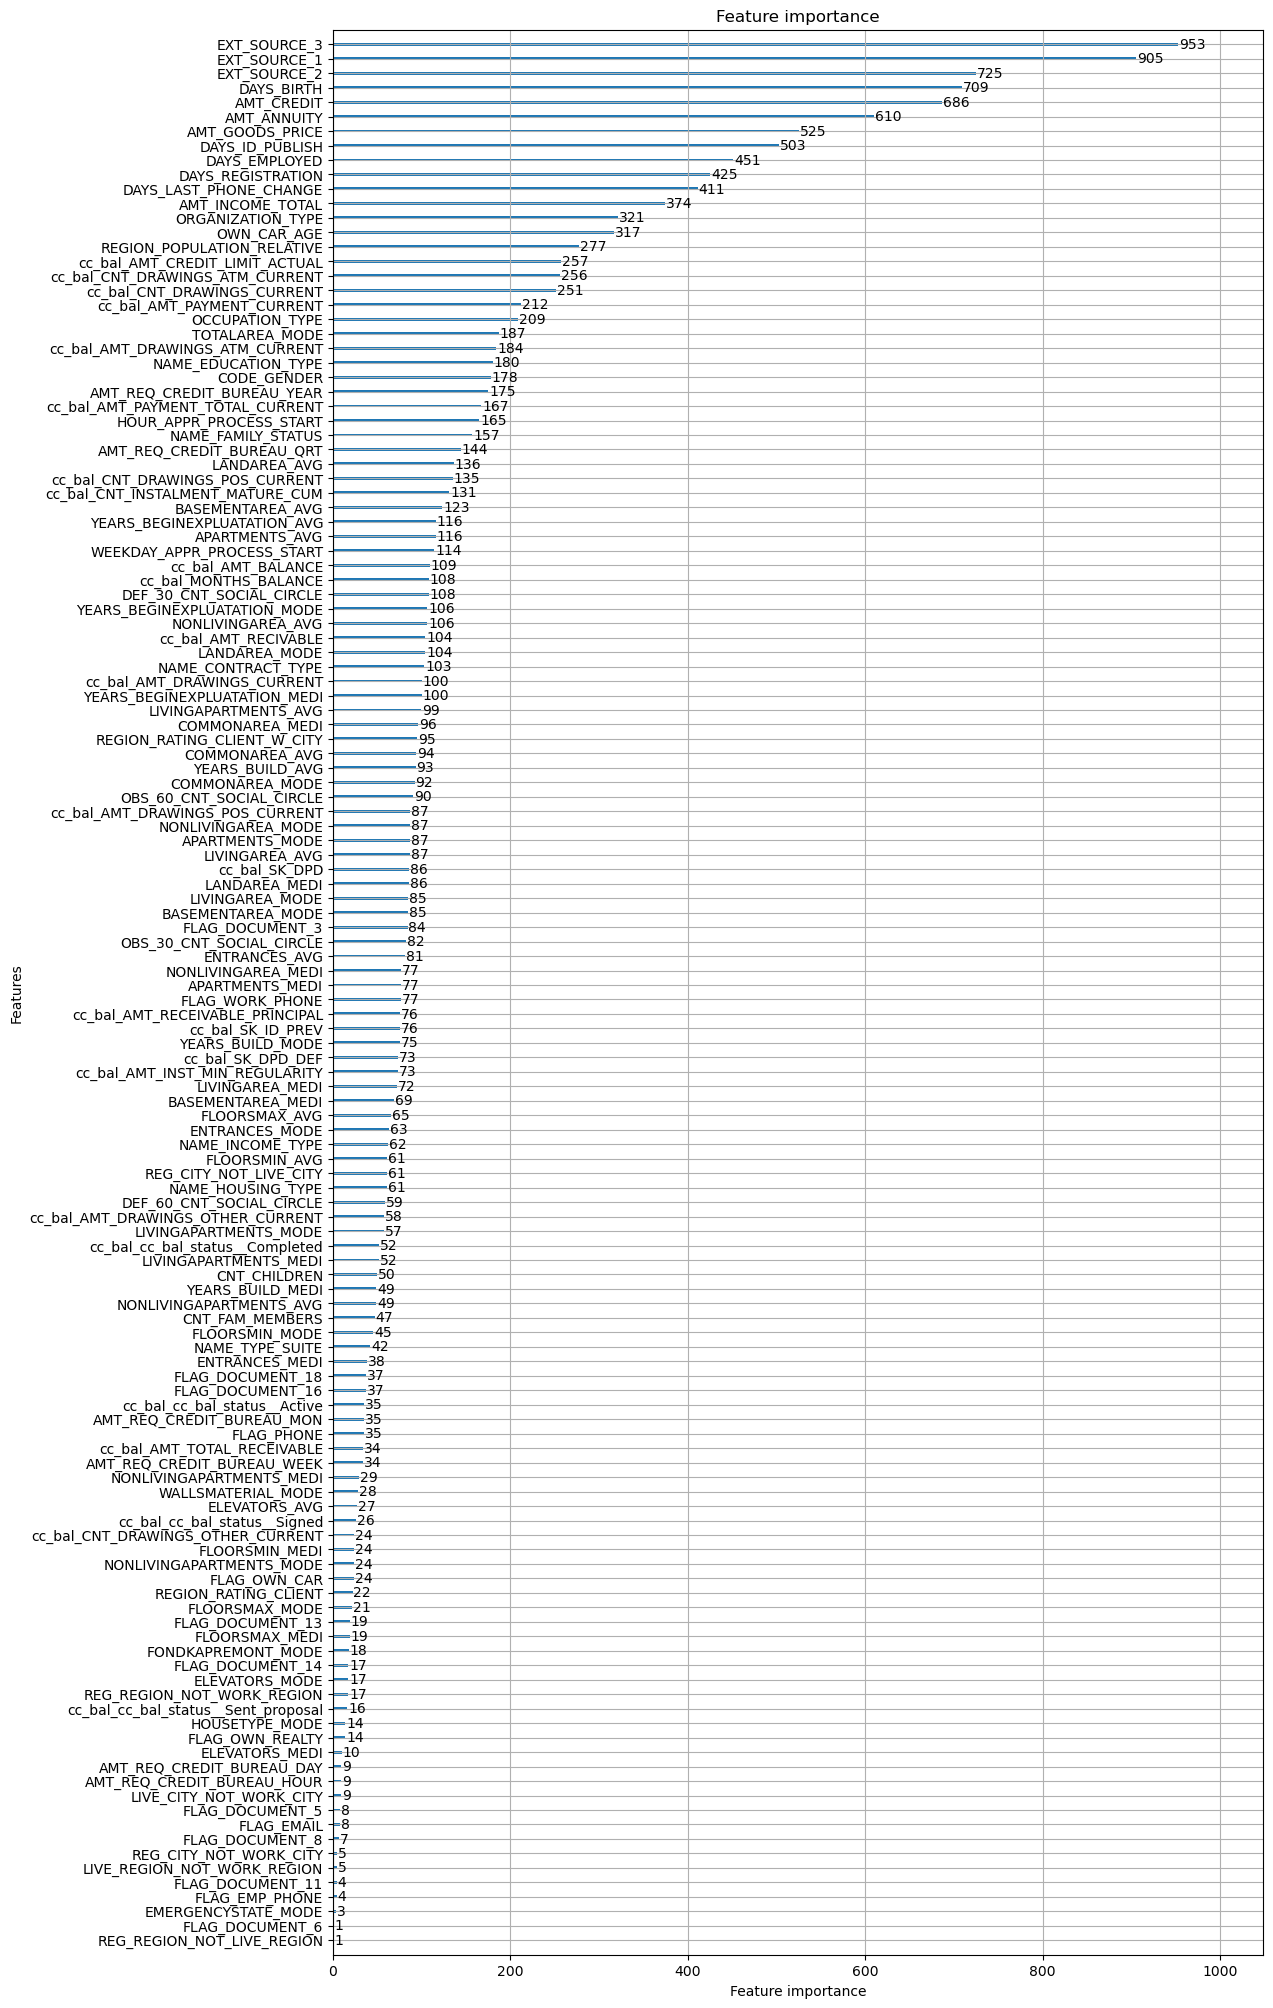

In [570]:
lgb.plot_importance(model, figsize=(12, 25), max_num_features=150);

In [571]:
y_pred_lgb = model.predict(X_test)
# sub_lgb = pd.DataFrame()
# sub_lgb['SK_ID_CURR'] = test_id
# sub_lgb['TARGET'] = preds
# sub_lgb.to_csv("lgb_baseline.csv", index=False)
# sub_lgb.head()

In [572]:
y_pred_lgb

array([0.19845721, 0.03883344, 0.13017383, ..., 0.03525186, 0.04343977,
       0.03150186])

In [573]:
y_pred_final_lgb = []
for my_pred in y_pred_lgb:
    if my_pred >= 0.35:
        y_pred_final_lgb.append(1)
    else:
        y_pred_final_lgb.append(0)
y_pred_final_lgb[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [574]:
print(classification_report(y_test, y_pred_final_lgb))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     56554
           1       0.43      0.10      0.17      4949

    accuracy                           0.92     61503
   macro avg       0.68      0.55      0.56     61503
weighted avg       0.89      0.92      0.89     61503



In [575]:
test_id = test['SK_ID_CURR']
preds = model.predict(X_t)
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_id

In [576]:
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("20220214_lgb_test_late_submission_testJM.csv", index=False)
sub_lgb.head()

,SK_ID_CURR,TARGET
0,100001,0.040172
1,100005,0.111722
2,100013,0.018803
3,100028,0.052812
4,100038,0.156694


## ----- Fin : Partie 1 : Analyse exploratoire -----